# PRM Model

In [28]:
import os
import json
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim

In [ ]:
# class LayerNormalization(nn.Module):
#     def __init__(self, eps=1e-6):
#         super(LayerNormalization, self).__init__()
#         self.eps = eps

#     def build(self, input_dim, device):
#         self.gamma = nn.Parameter(torch.ones(input_dim)).to(device)
#         self.beta = nn.Parameter(torch.zeros(input_dim)).to(device)

#     def forward(self, x):
#         if not hasattr(self, "gamma") or not hasattr(self, "beta"):
#             self.build(x.size(-1), x.device)
#         mean = x.mean(dim=-1, keepdim=True)
#         std = x.std(dim=-1, keepdim=True)
#         return self.gamma * (x - mean) / (std + self.eps) + self.beta

class TimeDistributed(nn.Module):
    def __init__(self, module, batch_first=False):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)

        y = self.module(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)

        return y

class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_model, dropout=0.1):
        super(ScaledDotProductAttention, self).__init__()
        self.scale = np.sqrt(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):
        attn = torch.matmul(q, k.transpose(-2, -1)) / self.scale
        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e10)
        attn = F.softmax(attn, dim=-1)
        attn = self.dropout(attn)
        output = torch.matmul(attn, v)
        return output, attn

class MultiHeadAttention(nn.Module):
    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v

        self.qs_linear = TimeDistributed(nn.Linear(d_model, n_head * d_k, bias=False), True)
        self.ks_linear = TimeDistributed(nn.Linear(d_model, n_head * d_k, bias=False), True)
        self.vs_linear = TimeDistributed(nn.Linear(d_model, n_head * d_v, bias=False), True)
        self.attention = ScaledDotProductAttention(d_model)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model)
        self.wo = TimeDistributed(nn.Linear(n_head * d_v, d_model), True)

    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)

        # Linear projections
        qs = self.qs_linear(q).view(batch_size, -1, self.n_head, self.d_k).transpose(1, 2)
        ks = self.ks_linear(k).view(batch_size, -1, self.n_head, self.d_k).transpose(1, 2)
        vs = self.vs_linear(v).view(batch_size, -1, self.n_head, self.d_v).transpose(1, 2)

        # Attention
        output, attn = self.attention(qs, ks, vs, mask)

        # Concatenate and apply final linear
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.n_head * self.d_v)
        output = self.dropout(self.wo(output))
        output = self.layer_norm(output + q)
        return output, attn

class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_inner, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.fc1 = nn.Conv1d(d_model, d_inner, kernel_size=1)
        self.fc2 = nn.Conv1d(d_inner, d_model, kernel_size=1)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, x):
        residual = x
        x = x.transpose(1, 2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.transpose(1, 2)
        x = self.dropout(x)
        return self.layer_norm(x + residual)

class EncoderLayer(nn.Module):
    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout)

    def forward(self, x, mask=None):
        x, attn = self.self_attn(x, x, x, mask)
        x = self.pos_ffn(x)
        return x, attn

class Encoder(nn.Module):
    def __init__(self, d_model, d_inner, n_head, d_k, d_v, num_layers, dropout=0.1):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout)
            for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        x = self.dropout(x)
        attns = []
        for layer in self.layers:
            x, attn = layer(x, mask)
            attns.append(attn)
        return x, attns

def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)]
        if pos != 0 else np.zeros(d_emb)
        for pos in range(max_len)
    ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])  # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])  # dim 2i+1
    return torch.tensor(pos_enc, dtype=torch.float)

def GetSubMask(s):
    len_s = s.size(1)
    mask = torch.tril(torch.ones((len_s, len_s), device=s.device))
    return mask.unsqueeze(0)

class DrrModel(nn.Module):
    def __init__(self, seq_len, d_feature, d_model=64, d_inner_hid=128, n_head=1, d_k=64, d_v=64, layers=2, dropout=0.1, model_type = 0, pos_mode = 0):
        super(DrrModel, self).__init__()
        self.seq_len = seq_len
        self.d_feature = d_feature
        self.d_model = d_model
        self.model_type = model_type
        if model_type == 1:
            self.uid_embedding = nn.Embedding(750000, 16) # for uid
            self.itemid_embedding = nn.Embedding(7500000, 32) # for icf1
            self.f1_embedding = nn.Embedding(8, 2) # for ucf1
            self.f2_embedding = nn.Embedding(4, 2) # for ucf2 & icf3
            self.f3_embedding = nn.Embedding(8, 2) # for ucf3 & icf4
            self.f4_embedding = nn.Embedding(4, 2) # for icf5
            self.f5_embedding = nn.Embedding(256, 4) # icf2

        self.dense = TimeDistributed(nn.Linear(d_feature, d_model), True)
        if pos_mode == 0:
            self.pos_embedding = nn.Embedding(seq_len, d_model, _weight=GetPosEncodingMatrix(seq_len, d_model), _freeze=True)
        elif pos_mode == 1:
            self.pos_embedding = nn.Embedding(seq_len, d_model)
        else:
            self.pos_embedding = None
        self.encoder = Encoder(d_model, d_inner_hid, n_head, d_k, d_v, layers, dropout)
        self.time_score_dense1 = TimeDistributed(nn.Linear(d_model, d_model))
        self.time_score_dense2 = TimeDistributed(nn.Linear(d_model, 1))

    def forward(self, v_input, pos_input, use_mask=False):
        if self.model_type == 0 or self.model_type == 2:
            d0 = self.dense(v_input)
        else:
            uid_input = v_input[:, :, 0].int()
            ucf1_input = v_input[:, :, 1].int()
            ucf2_input = v_input[:, :, 2].int()
            ucf3_input = v_input[:, :, 3].int()
            icf1_input = v_input[:, :, 4].int()
            icf2_input = v_input[:, :, 5].int()
            icf3_input = v_input[:, :, 6].int()
            icf4_input = v_input[:, :, 7].int()
            icf5_input = v_input[:, :, 8].int()
            v_input = v_input[:, :, 9:]
            #define user embedding
            u0 = self.uid_embedding(uid_input)
            u1 = self.f1_embedding(ucf1_input)
            u2 = self.f2_embedding(ucf2_input)
            u3 = self.f3_embedding(ucf3_input)
            #define item embedding
            i1 = self.itemid_embedding(icf1_input)
            i2 = self.f5_embedding(icf2_input)
            i3 = self.f2_embedding(icf3_input)
            i4 = self.f3_embedding(icf4_input)
            i5 = self.f4_embedding(icf5_input)
            #define page embedding: 16+2+2+2+32+4+2+2+2=64
            page_embedding = torch.cat([v_input, u0, u1, u2, u3, i1, i2, i3, i4, i5], dim=-1)
            d0 = self.dense(page_embedding)
        if self.pos_embedding is not None:
            p0 = self.pos_embedding(pos_input).squeeze(2)
            combine_input = d0 + p0
        else:
            combine_input = d0
        if use_mask:
            sub_mask = GetSubMask(pos_input)
        else:
            sub_mask = None

        enc_output, attn_weights = self.encoder(combine_input, mask=sub_mask)
        time_score = self.time_score_dense1(enc_output)
        time_score = torch.tanh(time_score)
        time_score = self.time_score_dense2(time_score).squeeze(-1)
        score_output = F.softmax(time_score, dim=-1)
        return score_output, attn_weights

In [3]:
# Data feature map
FEATURE_INFO_MAP = {
    "icf": ['icf1', 'icf2', 'icf3', 'icf4', 'icf5'],
    "ucf": ['ucf1', 'ufc2', 'ucf3'],
    "iv": ['iv1', 'iv2', 'iv3', 'iv4', 'iv5', 'iv6', 'iv7', 'iv8', 'iv9', 'iv10', 'iv11', 'iv12'],
    "pv": ['pv1', 'pv2', 'pv3', 'pv4', 'pv5', 'pv6', 'pv7'],
    "iv+pv": ['iv1', 'iv2', 'iv3', 'iv4', 'iv5', 'iv6', 'iv7', 'iv8', 'iv9', 'iv10', 'iv11', 'iv12', 'pv1', 'pv2', 'pv3', 'pv4', 'pv5', 'pv6', 'pv7']
}

# Utility functions
def get_pos(batch_size, seq_len):
    return torch.unsqueeze(torch.arange(seq_len).repeat(batch_size, 1), dim =-1)

def get_label(label_batch, batch_size, seq_len):
    outputs = np.zeros((batch_size, seq_len))
    for i, row in enumerate(label_batch):
        outputs[i] = np.array(json.loads(row))
    return torch.tensor(outputs, dtype=torch.float32)

def get_uid(features_batch, batch_size, seq_len):
    return torch.unsqueeze(torch.tensor([[uid] * seq_len for uid in features_batch], dtype=torch.int32), dim=-1)

def get_icf(features_batch, batch_size, seq_len):
    feature_len = len(FEATURE_INFO_MAP["icf"])
    outputs = [torch.zeros(batch_size, seq_len, dtype=torch.int32) for _ in range(feature_len)]
    for i, row in enumerate(features_batch):
        feature_data = np.array(json.loads(row.replace("null", "0")), dtype=np.int32).T
        for j in range(feature_len):
            outputs[j][i] = torch.tensor(feature_data[j])
    return torch.stack(outputs, dim = -1)

def get_ucf(features_batch, batch_size, seq_len):
    feature_len = len(FEATURE_INFO_MAP["ucf"])
    outputs = [torch.zeros(batch_size, seq_len, dtype=torch.int32) for _ in range(feature_len)]
    for i, row in enumerate(features_batch):
        feature_data = np.tile(np.array(json.loads(row.replace("null","1")), dtype=np.int32),(seq_len,1)).T
        for j in range(feature_len):
            outputs[j][i] = torch.tensor(feature_data[j])
    return torch.stack(outputs, dim = -1)

def get_iv(features_batch, batch_size, seq_len):
    feature_len = len(FEATURE_INFO_MAP['iv'])
    outputs = np.zeros((batch_size, seq_len, feature_len))
    for i, row in enumerate(features_batch):
        outputs[i] = np.array(json.loads(row))
    return torch.tensor(outputs, dtype = torch.float32)

def get_pv(features_batch, batch_size, seq_len):
    feature_len = len(FEATURE_INFO_MAP['pv'])
    outputs = np.zeros((batch_size, seq_len, feature_len))
    for i, row in enumerate(features_batch):
        outputs[i] = np.array(json.loads(row))
    return torch.tensor(outputs, dtype = torch.float32)

def get_iv_and_pv(iv_batch, pv_batch, batch_size, seq_len):
    iv = get_iv(iv_batch, batch_size, seq_len)
    pv = get_pv(pv_batch, batch_size, seq_len)
    return torch.dstack((iv, pv))

def get_features(uid_batch, ucf_batch, icf_batch, pv_batch, iv_batch, batch_size, seq_len, model_type):
    if model_type == 0:
        return [get_pos(batch_size, seq_len), get_iv(iv_batch, batch_size, seq_len)]
    elif model_type == 1:
        outputs = [get_uid(uid_batch, batch_size, seq_len)]
        outputs.append(get_ucf(ucf_batch, batch_size, seq_len))
        outputs.append(get_icf(icf_batch, batch_size, seq_len))
        outputs.append(get_iv(iv_batch, batch_size, seq_len))
        outputs.append(get_pv(pv_batch, batch_size, seq_len))
        outputs = torch.cat(outputs, dim=-1)
        return [get_pos(batch_size, seq_len), outputs]
    elif model_type == 2:
        return [get_pos(batch_size, seq_len), get_iv_and_pv(iv_batch, pv_batch, batch_size, seq_len)]

In [4]:
# Dataset and DataLoader
class CSVDataGenerator(Dataset):
    def __init__(self, filename, seq_len):
        self.data = np.loadtxt(filename, delimiter='|', dtype=str)
        self.seq_len = seq_len
        self.users = set(tuple(x) for x in [json.loads(x.replace("null", "0")) for x in self.data[:, 1]])
        self.items = set(np.array([json.loads(x.replace("null", "0")) for x in self.data[:, 2]])[:,:,0].reshape(-1).tolist())

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data[idx]
        uid, ucf, icf, pv, iv, label = row
        return {
            "uid": int(uid),
            "ucf": ucf,
            "icf": icf,
            "pv": pv,
            "iv": iv,
            "label": label
        }

def input_generator(filename, batch_size, seq_len, model_type):
    dataset = CSVDataGenerator(filename, seq_len)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    for batch in dataloader:
        batch_size = len(batch['uid'])
        yield get_features(
            batch['uid'], batch['ucf'], batch['icf'], batch['pv'], batch['iv'], batch_size, seq_len, model_type
        ), get_label(batch['label'], batch_size, seq_len)

In [5]:
# Configuration parameters (replacing TensorFlow FLAGS)
class Config:
    train = True
    train_set = "data/rec_train_set.sample.txt"
    validation_set = "data/rec_validation_set.sample.txt"
    test_set = "data/rec_test_set.sample.txt"
    log_dir = "log/"
    saved_model_name = "outputs/drr_model.pth"
    model_type = 1
    batch_size = 32
    seq_len = 30
    train_epochs = 5
    train_steps_per_epoch = 1000
    validation_steps = 10
    early_stop_patience = 10
    lr_per_step = 4000
    d_feature = 83
    d_model = 64
    d_inner_hid = 128
    n_head = 1
    d_k = 64
    d_v = 64
    n_layers = 2
    dropout = 0.1
    pos_embedding_mode = 1  # 0: fixed PE, 1: learnable PE, 2: no PE
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

CONFIG = Config()

In [6]:
train_gen = input_generator(CONFIG.train_set, CONFIG.batch_size, CONFIG.seq_len, CONFIG.model_type)
batch = next(train_gen)
print(batch[0][0].shape)
print(batch[0][1].shape)
print(batch[1].shape)

torch.Size([32, 30, 1])
torch.Size([32, 30, 28])
torch.Size([32, 30])


In [7]:
print(batch[0][1][0][0])

tensor([ 5.8673e+05,  7.0000e+00,  1.0000e+00,  4.0000e+00,  3.1608e+06,
         3.0000e+00,  1.0000e+00,  5.0000e+00,  1.0000e+00, -9.4926e-02,
        -8.2315e-01,  1.8298e-01, -7.3540e-01,  3.3305e-01,  1.0338e-01,
        -4.1636e-01,  1.0105e+00, -2.5875e-01, -1.3047e+00,  7.7116e-01,
        -1.4712e-01,  1.2377e-01, -3.7726e-01, -7.8553e-01, -2.6747e-01,
        -5.4612e-01,  5.0867e-01, -1.0410e+00])


In [8]:
class LRSchedulerPerStep:
    """
    Adjusts the learning rate per step based on the formula:
    lr = d_model^(-0.5) * min(step_num^(-0.5), step_num * warmup^(-1.5))

    Args:
        optimizer (torch.optim.Optimizer): Optimizer for which to adjust the learning rate.
        d_model (int): Dimensionality of the model (used in learning rate scaling).
        warmup (int): Number of warmup steps.
    """
    def __init__(self, optimizer, d_model, warmup=4000):
        self.optimizer = optimizer
        self.basic = d_model**-0.5
        self.warm = warmup**-1.5
        self.step_num = 0

    def step(self):
        """Updates the learning rate based on the current step."""
        self.step_num += 1
        lr = self.basic * min(self.step_num**-0.5, self.step_num * self.warm)
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

class LRSchedulerPerEpoch:
    """
    Adjusts the learning rate per epoch based on the formula:
    lr = d_model^(-0.5) * min(step_num^(-0.5), step_num * warmup^(-1.5))

    Args:
        optimizer (torch.optim.Optimizer): Optimizer for which to adjust the learning rate.
        d_model (int): Dimensionality of the model (used in learning rate scaling).
        warmup (int): Number of warmup steps.
        num_per_epoch (int): Number of steps per epoch.
    """
    def __init__(self, optimizer, d_model, warmup=4000, num_per_epoch=1000):
        self.optimizer = optimizer
        self.basic = d_model**-0.5
        self.warm = warmup**-1.5
        self.num_per_epoch = num_per_epoch
        self.step_num = 1

    def epoch_step(self):
        """Updates the learning rate at the start of each epoch."""
        self.step_num += self.num_per_epoch
        lr = self.basic * min(self.step_num**-0.5, self.step_num * self.warm)
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

In [9]:
# Training function
def train():
    print("Training...")
    os.makedirs(CONFIG.log_dir, exist_ok=True)
    device = CONFIG.device
    model = DrrModel(CONFIG.seq_len, CONFIG.d_feature, CONFIG.d_model, CONFIG.d_inner_hid, CONFIG.n_head, CONFIG.d_k, CONFIG.d_v, CONFIG.n_layers, CONFIG.dropout, CONFIG.model_type, CONFIG.pos_embedding_mode)
    if os.path.isfile(CONFIG.saved_model_name):
        print(f"Loading model from {CONFIG.saved_model_name}")
        model.load_state_dict(torch.load(CONFIG.saved_model_name, weights_only=True))
    print(sum(p.numel() for p in model.parameters() if p.requires_grad))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.001)

    running_loss = []

    # Initialize schedulers
    per_step_scheduler = LRSchedulerPerStep(optimizer, d_model=CONFIG.d_model, warmup=CONFIG.lr_per_step)

    # Training loop
    for epoch in range(CONFIG.train_epochs):
        model = model.to(device)
        model.train()
        running_loss_per_epoch = 0
        train_gen = input_generator(CONFIG.train_set, CONFIG.batch_size, CONFIG.seq_len, CONFIG.model_type)
        for step, (features, labels) in enumerate(train_gen):
            pos_input, v_input = features
            labels = labels.to(device)
            pos_input = pos_input.to(device)
            v_input = v_input.to(device)
            if step >= CONFIG.train_steps_per_epoch:
                break
            optimizer.zero_grad()
            outputs, _ = model(v_input, pos_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            per_step_scheduler.step()

            running_loss_per_epoch += loss.item()

            if (step+1) % 10 == 0:
                print(f"Epoch {epoch + 1}/{CONFIG.train_epochs}, Step {step + 1}/{CONFIG.train_steps_per_epoch}, Loss: {running_loss_per_epoch / (step + 1)}")
        loss_per_epoch = running_loss_per_epoch / (step + 1)
        running_loss.append(loss_per_epoch)
        print(f"Epoch {epoch + 1}/{CONFIG.train_epochs} completed.")
        torch.save(model.state_dict(), CONFIG.saved_model_name)

        model.eval()
        val_gen = input_generator(CONFIG.validation_set, CONFIG.batch_size, CONFIG.seq_len, CONFIG.model_type)
        losses = []
        for step, (features, labels) in enumerate(val_gen):
            pos_input, v_input = features
            labels = labels.to(device)
            pos_input = pos_input.to(device)
            v_input = v_input.to(device)
            if step >= CONFIG.validation_steps:
                break
            outputs, _ = model(v_input, pos_input)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
        print(f"Validation Loss: {np.mean(losses)}")

In [10]:
# Prediction function
def predict(mode = 'test'):
    print("Predicting...")
    model = DrrModel(CONFIG.seq_len, CONFIG.d_feature, CONFIG.d_model, CONFIG.d_inner_hid, CONFIG.n_head, CONFIG.d_k, CONFIG.d_v, CONFIG.n_layers, CONFIG.dropout, CONFIG.model_type, CONFIG.pos_embedding_mode)
    model.load_state_dict(torch.load(CONFIG.saved_model_name, weights_only=True))
    model.eval()

    if mode == 'test':
        gen = input_generator(CONFIG.test_set, CONFIG.batch_size, CONFIG.seq_len, CONFIG.model_type, shuffle = True)
    else:
        gen = input_generator(CONFIG.train_set, CONFIG.batch_size, CONFIG.seq_len, CONFIG.model_type, shuffle = True)
    preds = []
    for features, label_batch in gen:
        pos_enc, x = features
        predict_batch, _ = model(x, pos_enc)
        for labels, predicts in zip(label_batch, predict_batch):
            preds.append(predicts.detach().numpy())
            if sum(labels) > 0:  # predict valid labels
                new_ranks = np.argsort(-predicts.detach().numpy())
                new_labels = labels[new_ranks]
                with open(f"outputs/{mode}_predict.out", "a") as f:
                    f.write("%s\t%s\n" % (json.dumps(labels.tolist()), json.dumps(new_labels.tolist())))
    return np.vstack(preds)

In [ ]:
start_time = time.time()
train()
print(f"Job done! Time taken: {round((time.time() - start_time) / 60, 2)} minutes.")

In [ ]:
start_time = time.time()
CONFIG.train = False
train_preds = predict('train')
print(train_preds.shape)
print(f"Job done! Time taken: {round((time.time() - start_time) / 60, 2)} minutes.")

Predicting...


<ipython-input-9-f651ce9be9bb>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(CONFIG.saved_model_name))


8000
(8000, 30)
Job done! Time taken: 0.13 minutes.


In [ ]:
start_time = time.time()
CONFIG.train = False
test_preds = predict('test')
print(test_preds.shape)
print(f"Job done! Time taken: {round((time.time() - start_time) / 60, 2)} minutes.")

Predicting...


<ipython-input-11-21581ff2556b>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(CONFIG.saved_model_name))


1000
(1000, 30)
Job done! Time taken: 0.03 minutes.


In [ ]:
import sys, json

def calc_average_precision_at_k(labels, k):
    n = min(len(labels),k)
    labels = labels[:n]
    p = []
    p_cnt = 0
    for i in range(n):
        if labels[i]>0:
            p_cnt+=1
            p.append(p_cnt*1.0/(i+1))
    if p_cnt > 0:
        return sum(p)/p_cnt
    else:
        return 0.0

def calc_precision_at_k(labels, k):
    n = min(len(labels),k)
    labels = labels[:n]
    p_cnt = 0
    for i in range(n):
        if labels[i]>0:
            p_cnt+=1
    return p_cnt*1.0/n

def make_metric_dict():
    return { 'p@5':0, 'p@10':0, 'p@1':0, 'map@5':0, 'map@10':0, 'map@30':0 }

metric_keys = [ 'p@5', 'p@10', 'map@5', 'map@10', 'map@30' ]
filename = "outputs/train_predict.out"
print("calc metric from %s" % filename)
with open(filename, 'r') as f:
    cnt = 0
    d = {} # for stat
    for line in f:
        try:
            step_labels = [ json.loads(labels) for labels in line.strip().split("\t") ]
        except:
            print(line)
            continue
        n = len(step_labels)
        for i in range(n):
            if not i in d:
                d[i] = make_metric_dict()
            d[i]['p@5'] += calc_precision_at_k(step_labels[i], 5)
            d[i]['p@10'] += calc_precision_at_k(step_labels[i], 10)
            d[i]['map@5'] += calc_average_precision_at_k(step_labels[i], 5)
            d[i]['map@10'] += calc_average_precision_at_k(step_labels[i], 10)
            d[i]['map@30'] += calc_average_precision_at_k(step_labels[i], 30)
        cnt+=1
    f.close()
    n = len(d)
    print('total_record_cnt=%d step_range=[0,%d]' % (cnt, n-1))
    for i in range(n):
        info = ["step=%d" % i]
        for key in metric_keys:
            info.append("%s=%0.2f" % (key, d[i][key] * 100.0/cnt))
        print(" ".join(info))

# Dataset Statistics

In [11]:
dataset = CSVDataGenerator(CONFIG.train_set, CONFIG.seq_len)

In [12]:
print(len(set(dataset.items)))

142998


In [14]:
print(len(dataset.users))

150


# Get Item Relevance

In [ ]:
item_relevance_map = {}
train_preds = train_preds.reshape(-1)
for idx, item in enumerate(dataset.items):
    if item not in item_relevance_map:
        item_relevance_map[item] = [train_preds[idx]]
    else:
        item_relevance_map[item].append(train_preds[idx])
print(len(item_relevance_map))

In [ ]:
item_relevances = [np.median(values) for values in item_relevance_map.values()]
item_relevances = np.array(item_relevances)
print(item_relevances.shape)
print(item_relevances[:5])

(142998,)
[9.9991620e-01 2.7886813e-06 2.8790153e-06 2.8542470e-06 3.1123552e-06]


In [ ]:
item_relevances = F.softmax(torch.tensor(item_relevances), dim=-1)
item_relevances = item_relevances.detach().numpy()
print(item_relevances[:5])

[1.8023215e-05 6.6309444e-06 6.6309444e-06 6.6309444e-06 6.6309467e-06]


# Time Constrained Recommendation

In [ ]:
%pip install xgboost
%pip install scikit-learn
%pip install joblib
%pip install pandas

In [ ]:
import functools
import sklearn.preprocessing
import scipy.special

import sklearn.model_selection
from xgboost import XGBRegressor
from sklearn.metrics import roc_auc_score
import pandas as pd
from joblib import Parallel, delayed

In [ ]:
# Define the UserWithPredefBudget class
class UserWithPredefBudget:
    def __init__(
            self,
            config,
            initial_budget,
            default_no_choice_logit=torch.tensor(1.0),
            name="UserWithBudget"
        ):

        self.name = name
        self.slate_size = config.get("slate_size")
        self._num_users = config.get("num_users")

        self.default_no_choice_logit = default_no_choice_logit * torch.ones(self._num_users)
        self.initial_budget = torch.tensor(initial_budget.astype(np.float32))
        self.choice_model = MultinomialLogitChoiceModel(
            batch_shape=(self._num_users,), nochoice_logits=self.default_no_choice_logit)

    def initial_state(self):
        return {'budget': self.initial_budget}

    def generate_watched_vector(self, slate_doc_costs, previous_state):
        cumulative_cost = torch.cumsum(slate_doc_costs, dim=1)
        temp = previous_state['budget'][..., None]
        watched = torch.where(cumulative_cost < temp,
                                torch.ones_like(cumulative_cost),
                                torch.zeros_like(cumulative_cost))
        return watched

    def next_state(self, previous_state, slate_docs):
        return {'budget': previous_state['budget']}

    def next_response(self, previous_state, slate_docs):
        # relevances are in log-scale
        slate_doc_relevances = slate_docs['relevances']
        slate_doc_costs = slate_docs['costs']

        watched = self.generate_watched_vector(slate_doc_costs, previous_state)

        adjusted_scores = watched * slate_doc_relevances
        adjusted_scores_1 = torch.where(adjusted_scores == 0,
                                        torch.tensor(-np.Inf) * torch.ones_like(adjusted_scores),
                                        adjusted_scores)

        logits = torch.cat((adjusted_scores_1, self.default_no_choice_logit[..., None]), dim=-1)
        choice = self.choice_model.choice(logits)['choice']
        return {'choice': choice, 'logits': logits, 'watched': watched}

    def observation(self):
        pass

# Define the MultinomialLogitChoiceModel class
class MultinomialLogitChoiceModel:
    def __init__(self, batch_shape, nochoice_logits):
        self.batch_shape = batch_shape
        self.nochoice_logits = nochoice_logits

    def choice(self, logits):
        # logits shape: batch_size x num_choices
        probs = torch.softmax(logits, dim=-1)
        choices = torch.multinomial(probs, 1).squeeze(-1)
        return {'choice': choices}

# Define the RelevanceAndCostCorpus class
class RelevanceAndCostCorpus:
    def __init__(
            self,
            config,
            doc_costs,
            doc_relevances,
            name="RelevanceAndCostCorpus"
        ):
        self.name = name
        self._num_users = config.get("num_users")
        self.doc_costs = torch.tensor(doc_costs.astype(np.float32))
        self.doc_relevances = torch.tensor(doc_relevances.astype(np.float32))

    def initial_state(self):
        return {'relevances': self.doc_relevances, 'costs': self.doc_costs}

    def next_state(self, previous_state):
        return previous_state

    def available_documents(self, corpus_state):
        """The available_documents value."""
        return corpus_state

# Define the PrecomputedSlatesRecommender class
class PrecomputedSlatesRecommender:
    def __init__(
            self,
            config,
            user_slates
        ):
        self.slate_size = config.get("slate_size")
        self._num_users = config.get("num_users")
        self._num_docs = config.get("num_docs")
        self.user_slates = user_slates

    def slate_docs(self, user_state, corpus_state):
        doc_relevances = corpus_state['relevances']
        doc_costs = corpus_state['costs']
        doc_relevances_rep = doc_relevances.unsqueeze(0).repeat(self._num_users, 1)
        doc_costs_rep = doc_costs.unsqueeze(0).repeat(self._num_users, 1)

        indices = torch.tensor(self.user_slates, dtype=torch.int64)
        slate_doc_relevances = torch.gather(doc_relevances_rep, 1, indices)
        slate_doc_costs = torch.gather(doc_costs_rep, 1, indices)

        return {
            'relevances': slate_doc_relevances,
            'costs': slate_doc_costs,
            'indices': indices
        }

In [ ]:
def get_simulation_variables(
        num_users=1000,
        horizon=1,
        slate_size=10,
        num_docs=100,
        user_initial_budget=None,
        doc_costs=None,
        doc_relevances=None,
        user_slates=None,
        default_no_choice_logit=4.0,
        seed=0
    ):

    torch.manual_seed(seed)
    num_topics = 2
    config = {
        "slate_size": slate_size,
        "num_users": num_users,
        "num_topics": num_topics,
        "num_docs": num_docs
    }

    # Instantiate the user with predefined budget
    gt_user = UserWithPredefBudget(
        config=config,
        initial_budget=user_initial_budget,
        default_no_choice_logit=torch.tensor(default_no_choice_logit, dtype=torch.float32)
    )


    gt_corpus = RelevanceAndCostCorpus(
        config=config,
        doc_costs=doc_costs,
        doc_relevances=doc_relevances
    )


    gt_recommender = PrecomputedSlatesRecommender(
        config=config,
        user_slates=user_slates
    )

    # Simulate the story
    def my_recs_story(
            config,
            user,
            corpus,
            recommender
        ):
        user_state = user.initial_state()
        corpus_state = corpus.initial_state()
        slate_docs = recommender.slate_docs(user_state, corpus_state)
        user_response = user.next_response(user_state, slate_docs)
        return {
            'user_state': user_state,
            'corpus_state': corpus_state,
            'slate_docs': slate_docs,
            'user_response': user_response
        }

    gt_variables = my_recs_story(config, gt_user, gt_corpus, gt_recommender)
    return gt_variables

def get_simulation_data(
        num_users=1000,
        horizon=1,
        slate_size=10,
        num_docs=100,
        user_initial_budget=None,
        doc_costs=None,
        doc_relevances=None,
        user_slates=None,
        default_no_choice_logit=4.0,
        seed=0
    ):
    gt_variables = get_simulation_variables(
        num_users,
        horizon,
        slate_size,
        num_docs,
        user_initial_budget,
        doc_costs,
        doc_relevances,
        user_slates,
        default_no_choice_logit,
        seed
    )
    traj = {
        'user_state': gt_variables['user_state'],
        'corpus_state': gt_variables['corpus_state'],
        'slate_docs': gt_variables['slate_docs'],
        'user_response': gt_variables['user_response']
    }
    return traj

def compute_metrics(traj, slate_size, num_users):
    choice = traj['user_response']['choice'].numpy()
    slate_level_response = choice != slate_size
    play_rate = slate_level_response.sum() / num_users

    impression = traj['user_response']['watched'].numpy()
    return play_rate, np.mean(impression.sum(axis=1))

def learn_optimal_q_function(
        traj,
        xgb_model,
        call_count,
        discount_factor,
        num_users,
        slate_size,
        all_item_relevances,
        all_item_costs,
        num_iter
    ):

    feature_data = generate_feature_data(num_users, slate_size, traj)

    immediate_reward = feature_data[0]
    stacked_training_features = feature_data[1]
    pregenerate_indices_for_next_state_action = feature_data[2]
    validation_positive_pages_repeated = feature_data[3]
    validation_positive_page_features = feature_data[4]
    validation_negative_pages_repeated = feature_data[5]
    validation_negative_page_features = feature_data[6]
    slates_above_list = feature_data[7]
    # print(slates_above_list)

    xgb_model = train_xgb_model_for_qlearning(
        immediate_reward,
        xgb_model,
        stacked_training_features,
        pregenerate_indices_for_next_state_action,
        call_count,
        discount_factor,
        slates_above_list,
        all_item_relevances,
        all_item_costs,
        num_iter
    )

    auc_score = compute_auc_score(
        xgb_model,
        validation_positive_pages_repeated,
        validation_positive_page_features,
        validation_negative_pages_repeated,
        validation_negative_page_features
    )

    return xgb_model, auc_score

def update_q_function(traj, xgb_model, call_count, discount_factor, num_users, slate_size):

    feature_data = \
        generate_feature_data(num_users, slate_size, traj)

    immediate_reward = feature_data[0]
    stacked_training_features = feature_data[1]
    pregenerate_indices_for_next_state_action = feature_data[2]
    validation_positive_pages_repeated = feature_data[3]
    validation_positive_page_features = feature_data[4]
    validation_negative_pages_repeated = feature_data[5]
    validation_negative_page_features = feature_data[6]

    xgb_model = train_xgb_model(
        immediate_reward,
        xgb_model,
        stacked_training_features,
        pregenerate_indices_for_next_state_action,
        call_count,
        discount_factor
    )

    auc_score = compute_auc_score(
        xgb_model,
        validation_positive_pages_repeated,
        validation_positive_page_features,
        validation_negative_pages_repeated,
        validation_negative_page_features
    )

    return xgb_model, auc_score

def generate_feature_data(num_users, slate_size, traj):

    feature_df = unroll_traj_in_feature_df(num_users, slate_size, traj)

    page_level_labels = feature_df.groupby('page_ind')['label'].sum().reset_index()

    positive_pages = page_level_labels[page_level_labels.label == 1].page_ind.values

    negative_pages = page_level_labels[page_level_labels.label == 0].page_ind.values

    # print('positive_pages.shape, negative_pages.shape: ', positive_pages.shape, negative_pages.shape)

    (training_positive_pages, validation_positive_pages,
     training_negative_pages, validation_negative_pages) = give_train_test_split(positive_pages, negative_pages)

    training_feature_df = \
        feature_df[feature_df.page_ind.isin(np.concatenate([training_positive_pages, training_negative_pages]))]
    training_feature_df = training_feature_df.sort_values(by=['page_ind', 'row_position'])

    immediate_reward = training_feature_df.label.values

    stacked_training_features = featurize(training_feature_df)
    slates_above_list = construct_slates_above(training_feature_df)

    temp = feature_df[feature_df.page_ind.isin(validation_positive_pages)]
    temp = temp.sort_values(by=['page_ind', 'row_position'])

    validation_positive_pages_repeated = temp.page_ind.values

    validation_positive_page_features = featurize(temp)

    temp = feature_df[feature_df.page_ind.isin(validation_negative_pages)]
    temp = temp.sort_values(by=['page_ind', 'row_position'])
    validation_negative_pages_repeated = temp.page_ind.values

    validation_negative_page_features = featurize(temp)

    pre_generated_ids_for_next_state_action = pre_generate_ids_for_next_state_action(
        training_feature_df.page_ind.values,
        np.unique(training_feature_df.page_ind.values)
    )

    return (
        immediate_reward,
        stacked_training_features,
        pre_generated_ids_for_next_state_action,
        validation_positive_pages_repeated,
        validation_positive_page_features,
        validation_negative_pages_repeated,
        validation_negative_page_features,
        slates_above_list
    )

def construct_slates_above(feature_df):
    slates_above_list = []
    slates_above_for_current_page = []
    prev_page_ind = -1
    for ind, row in feature_df.iterrows():
        if row.page_ind != prev_page_ind:
            slates_above_for_current_page = []
        slates_above_list.append(slates_above_for_current_page)
        slates_above_for_current_page = list.copy(slates_above_for_current_page)
        slates_above_for_current_page.append(int(row.item_id))
        prev_page_ind = row.page_ind

    return slates_above_list

def train_xgb_model_for_qlearning(
        immediate_reward,
        xgb_model,
        stacked_training_features,
        pre_generated_ids_for_next_state_action,
        call_count,
        discount_factor,
        slates_above_list,
        all_item_relevances,
        all_item_costs,
        num_iter
    ):

    # repeat each row num_items times
    repeated_stacked_training_features = np.repeat(
        stacked_training_features,
        all_item_relevances.shape[0],
        axis=0
    )
    # repeat the entire relevance and cost array num_samples times
    repeated_relevances = np.tile(all_item_relevances, (stacked_training_features.shape[0]))
    repeated_costs = np.tile(all_item_costs, (stacked_training_features.shape[0]))

    repeated_stacked_training_features[:, 1] = repeated_relevances
    repeated_stacked_training_features[:, 2] = repeated_costs

    # print('call_count', call_count)
    for n_iter in np.arange(num_iter):
        td_targets = compute_qlearning_target(
            immediate_reward,
            xgb_model,
            stacked_training_features.shape[0],
            repeated_stacked_training_features,
            pre_generated_ids_for_next_state_action,
            discount_factor,
            slates_above_list
        )
        if xgb_model is not None:
            # print('warm starting ...')
            xgb_model = XGBRegressor(
                objective='reg:squarederror',
                n_estimators=1,
                learning_rate=0.1 / call_count,
                n_jobs=24,
                verbosity=1
            ).fit(
                stacked_training_features,
                td_targets,
                xgb_model=xgb_model.get_booster()
            )
        else:
            # print('cold starting ...')
            xgb_model = XGBRegressor(
                objective='reg:squarederror',
                n_estimators=1,
                n_jobs=24,
                verbosity=3
            ).fit(
                stacked_training_features,
                td_targets
            )

    return xgb_model

def compute_qlearning_target(
        immediate_reward,
        model,
        n_samples,
        repeated_stacked_training_features,
        pregenerate_indices_for_next_state_action,
        discount_factor,
        slates_above_list
    ):
    if model is not None:
        predicted_q_values_all_actions = model.predict(repeated_stacked_training_features)
        predicted_q_values_all_actions = np.reshape(predicted_q_values_all_actions, (n_samples, -1))

        # print(predicted_q_values_all_actions.shape , len(slates_above_list))

        # apply masking
        for ind, slate_above in enumerate(slates_above_list):
            predicted_q_values_all_actions[ind, slate_above] = -np.Inf

        optimal_q_values_for_next_step = predicted_q_values_all_actions.max(axis=1)

        target = np.zeros_like(immediate_reward)

        target[pregenerate_indices_for_next_state_action] = \
            optimal_q_values_for_next_step[pregenerate_indices_for_next_state_action + 1]
        target = immediate_reward + discount_factor * target
        return target
    else:
        return np.array(immediate_reward)

def unroll_traj_in_feature_df(num_users, slate_size, traj):

    slate_costs = traj['slate_docs']['costs'].numpy()
    slate_relevance_features = traj['slate_docs']['relevances'].numpy()
    item_ids = traj['slate_docs']['indices'].numpy()
    choice_index = traj['user_response']['choice'].numpy()
    user_budget = traj['user_state']['budget'].numpy()

    label = np.zeros((num_users, slate_size + 1))
    label[np.arange(num_users), choice_index] = 1
    label = label[:, :-1]

    impression = traj['user_response']['watched'].numpy()
    print('avg impressions,', np.mean(impression.sum(axis=1)))
    x1 = np.repeat(np.arange(num_users), slate_size)
    x2 = np.tile(np.arange(slate_size), num_users)
    x3 = np.ravel(item_ids)

    x4 = np.ravel(slate_relevance_features)
    x5 = np.ravel(impression)
    x6 = np.ravel(label)

    x7 = np.ravel(slate_costs)
    x8 = np.repeat(user_budget, slate_size)

    # print(x1.shape, x2.shape, x3.shape, x4.shape, x5.shape, x6.shape)
    feature_df = pd.DataFrame({
        'page_ind': x1,
        'row_position': x2,
        'item_id': x3,
        'relevance': x4,
        'impression': x5,
        'label': x6,
        'cost': x7,
        'user_budget': x8})

    return feature_df

def give_train_test_split(positive_pages, negative_pages):
    smaller_size = min(positive_pages.shape[0], negative_pages.shape[0])

    # training_positive_pages, validation_positive_pages = \
    #     sklearn.model_selection.train_test_split(positive_pages,
    #                                              train_size=int(0.80 * smaller_size),
    #                                              test_size=int(0.2 * smaller_size))
    
    training_positive_pages, validation_positive_pages = \
        sklearn.model_selection.train_test_split(positive_pages,
                                                 test_size=0.2)

    # print('Positive Pages Train/Val Split: ',
    #      training_positive_pages.shape, validation_positive_pages.shape)

    training_negative_pages, validation_negative_pages = \
        sklearn.model_selection.train_test_split(
            negative_pages,
            train_size=training_positive_pages.shape[0],
            test_size=validation_positive_pages.shape[0]
        )

    # print('Negatives Pages Train/Val Split:', training_negative_pages.shape,
    #      validation_negative_pages.shape)

    training_positive_pages = np.sort(training_positive_pages)
    validation_positive_pages = np.sort(validation_positive_pages)

    training_negative_pages = np.sort(training_negative_pages)
    validation_negative_pages = np.sort(validation_negative_pages)

    return (training_positive_pages, validation_positive_pages,
            training_negative_pages, validation_negative_pages)

# row_position, relevance, cost, budget_to_go, cumulative_relevance
def featurize(feature_df):
    return np.hstack(
        [feature_df.row_position.values[..., np.newaxis],
        feature_df.relevance.values[..., np.newaxis],
        feature_df.cost.values[..., np.newaxis],
        get_budget_before_impression(feature_df)[..., np.newaxis],
        get_cumulative_relevance(feature_df)[..., np.newaxis]]
    )

def get_budget_before_impression(feature_df):
    budget_before_impression_all = np.zeros(feature_df.shape[0])
    start_ind = 0
    for p in np.sort(np.unique(feature_df.page_ind.values)):
        costs_for_page_p = \
            feature_df[feature_df.page_ind == p].cost.values

        cumulative_costs = np.cumsum(costs_for_page_p)
        cumulative_costs = np.roll(cumulative_costs, shift=1)
        cumulative_costs[0] = 0.0
        user_budget_for_page_p = feature_df[feature_df.page_ind == p].user_budget.values
        budget_before_impression_all[start_ind: start_ind + user_budget_for_page_p.shape[0]] = \
            user_budget_for_page_p - cumulative_costs

        start_ind += user_budget_for_page_p.shape[0]
    return budget_before_impression_all

def get_cumulative_relevance(feature_df):
    cumulative_relevance = np.zeros(feature_df.shape[0])
    start_ind = 0
    for p in np.sort(np.unique(feature_df.page_ind.values)):
        relevances_for_page_p = \
            feature_df[feature_df.page_ind == p].relevance.values
        relevances_for_page_p = np.roll(relevances_for_page_p, shift=1)
        relevances_for_page_p[0] = 0.0

        cumulative_relevance_for_page_p = np.cumsum(np.exp(relevances_for_page_p))
        cumulative_relevance[start_ind: start_ind + relevances_for_page_p.shape[0]] = \
            cumulative_relevance_for_page_p
        start_ind += relevances_for_page_p.shape[0]
    return cumulative_relevance

def pre_generate_ids_for_next_state_action(all_ids, unique_ids):
    inds_list = []
    for s in unique_ids:
        inds = np.where(all_ids == s)[0]
        if len(inds) > 1:
            inds_list.append(np.arange(inds[0], inds[-1]))
    return np.concatenate(inds_list)

def train_xgb_model(
        immediate_reward,
        xgb_model,
        stacked_training_features,
        pre_generated_ids_for_next_state_action,
        call_count,
        discount_factor
    ):

    # print('call_count', call_count)
    for n_iter in np.arange(1):
        td_targets = compute_td_target_fast(
            immediate_reward,
            xgb_model,
            stacked_training_features,
            pre_generated_ids_for_next_state_action,
            discount_factor
        )
        if xgb_model is not None:
            # print('warm starting ...')
            xgb_model = XGBRegressor(
                objective='reg:squarederror',
                n_estimators=1,
                learning_rate=0.1 / call_count,
                n_jobs=24,
                verbosity=1
            ).fit(
                stacked_training_features,
                td_targets,
                xgb_model=xgb_model.get_booster()
            )
        else:
            # print('cold starting ...')
            xgb_model = XGBRegressor(
                objective='reg:squarederror',
                n_estimators=1,
                n_jobs=24,
                verbosity=3
            ).fit(
                stacked_training_features,
                td_targets
            )

    return xgb_model

def compute_td_target_fast(
        immediate_reward,
        model,
        feature_matrix,
        pregenerate_indices_for_next_state_action,
        discount_factor
    ):
    if model is not None:
        target = np.zeros_like(immediate_reward)
        predicted_q_values_next_s_a = model.predict(feature_matrix)
        target[pregenerate_indices_for_next_state_action] = \
            predicted_q_values_next_s_a[pregenerate_indices_for_next_state_action + 1]
        target = immediate_reward + discount_factor * target
        return target
    else:
        return np.array(immediate_reward)

def compute_auc_score(
        xgb_model,
        validation_positive_pages_repeated,
        validation_positive_page_features,
        validation_negative_pages_repeated,
        validation_negative_page_features
    ):

    positive_df = pd.DataFrame({
        'page_ind': validation_positive_pages_repeated,
        'predictions': xgb_model.predict(validation_positive_page_features)
    })

    negative_df = pd.DataFrame({
        'page_ind': validation_negative_pages_repeated,
        'predictions': xgb_model.predict(validation_negative_page_features)
    })

    abandoned_pages_score = negative_df.groupby('page_ind')['predictions'].apply(np.mean).reset_index()
    novel_play_page_score = positive_df.groupby('page_ind')['predictions'].apply(np.mean).reset_index()

    y_true = np.concatenate([np.ones_like(novel_play_page_score['predictions'].values),
                             np.zeros_like(abandoned_pages_score['predictions'].values)])

    y_pred = np.concatenate([novel_play_page_score['predictions'].values,
                             abandoned_pages_score['predictions'].values])

    return roc_auc_score(y_true=y_true, y_score=y_pred)

def generate_user_slates(
        xgb_model,
        all_user_budgets,
        relevance_all_items,
        epsilon,
        cost_all_items,
        num_users,
        slate_size,
        num_docs,
        seed
    ):
    block_level_states = \
        Parallel(n_jobs=32)(delayed(generate_user_slate_block)(
            xgb_model,
            all_user_budgets,
            relevance_all_items,
            epsilon,
            cost_all_items,
            num_users,
            slate_size,
            num_docs,
            seed,
            block_ind
        ) for block_ind in np.arange(32))

    user_slates_a = np.zeros((num_users, slate_size), np.int32)
    for block in block_level_states:
        for u in block:
            user_slates_a[u[0], :] = np.array(u[1])
    return user_slates_a

def generate_user_slate_block(
        xgb_model,
        all_user_budgets,
        relevance_all_items,
        epsilon,
        cost_all_items,
        num_users,
        slate_size,
        num_docs,
        seed,
        block_ind
    ):
    part_size = int(np.ceil(num_users / 32))
    max_ind = min((block_ind + 1) * part_size, num_users)
    block_level_states = []
    for nu in np.arange(block_ind * part_size, max_ind):
        block_level_states.append(generate_user_slate(
            xgb_model, all_user_budgets,
            relevance_all_items, epsilon,
            cost_all_items, slate_size, num_docs, nu, seed
        ))
    return block_level_states

def generate_user_slate(
        xgb_model,
        all_user_budgets,
        relevance_all_items,
        epsilon,
        cost_all_items,
        slate_size,
        num_docs,
        user_ind,
        seed
    ):
    chosen_actions = []
    user_budget_to_go = all_user_budgets[user_ind]
    cumulative_relevance_so_far = np.exp(0)
    for k in np.arange(slate_size):
        feature_matrix = generate_feature_matrix(
            k,
            relevance_all_items,
            cost_all_items,
            user_budget_to_go,
            cumulative_relevance_so_far,
            num_docs
        )
        predicted_q_values = xgb_model.predict(feature_matrix)
        predicted_q_values[chosen_actions] = -np.Inf
        chosen_action = epsilon_greedy_policy(predicted_q_values, epsilon, chosen_actions, seed)
        chosen_actions.append(chosen_action)
        user_budget_to_go -= cost_all_items[chosen_action]
        cumulative_relevance_so_far += np.exp(relevance_all_items[chosen_action])
    return user_ind, chosen_actions

# row_position, relevance, cost, budget_to_go
def generate_feature_matrix(
        row_position,
        relevance_all_items,
        cost_all_items,
        budget_to_go,
        cumulative_relevance_so_far,
        num_docs
    ):

    return np.hstack(
        [np.repeat(row_position, num_docs)[..., np.newaxis],
        relevance_all_items[..., np.newaxis],
        cost_all_items[..., np.newaxis],
        np.repeat(budget_to_go, num_docs)[..., np.newaxis],
        np.repeat(cumulative_relevance_so_far, num_docs)[..., np.newaxis]]
    )

def epsilon_greedy_policy(predicted_q_values, epsilon, current_slate, seed):
    probs = get_epsilon_greedy_policy_prob(predicted_q_values, current_slate, epsilon)
    np.random.seed(seed)
    return np.random.choice(predicted_q_values.shape[0], size=1, replace=True, p=probs)[0]

def get_epsilon_greedy_policy_prob(predicted_q_values, current_slate, epsilon):
    best_action = np.argmax(predicted_q_values)

    remaining_slate_size = predicted_q_values.shape[0] - len(current_slate)
    probs = np.ones(predicted_q_values.shape[0]) * (epsilon / remaining_slate_size)
    probs[current_slate] = 0
    probs[best_action] += (1 - epsilon)
    return probs

def get_random_user_slates(num_users, slate_size, num_docs):
    user_slates = np.zeros((num_users, slate_size), np.int32)
    for nu in np.arange(num_users):
        user_slates[nu, :] = np.random.choice(np.arange(num_docs), size=slate_size, replace=False)

    return user_slates

In [ ]:
def run_sarsa(
        num_users,
        slate_size,
        num_docs,
        user_initial_budget,
        doc_costs,
        doc_relevances,
        discount_factor,
        num_iter=25,
        seed=0
    ):
    np.random.seed(seed)
    xgb_model = None
    epsilon = 0.1
    user_slates = get_random_user_slates(num_users, slate_size, num_docs)
    # print(user_slates[0])
    results = []
    traj_list = []
    for iter_ind in range(num_iter):
        print(iter_ind, ',generating simulated data ')

        traj = get_simulation_data(
            num_users=num_users,
            slate_size=slate_size,
            num_docs=num_docs,
            user_initial_budget=user_initial_budget,
            doc_costs=doc_costs,
            doc_relevances=doc_relevances,
            user_slates=user_slates,
            default_no_choice_logit=4.0,
            seed=seed
        )

        metrics = compute_metrics(traj, slate_size, num_users)
        xgb_model, auc_score = update_q_function(
            traj=traj,
            xgb_model=xgb_model,
            call_count=iter_ind + 1,
            discount_factor=discount_factor,
            num_users=num_users,
            slate_size=slate_size
        )

        print(iter_ind, ',play_rate, avg_impressions:', metrics, ',auc:', auc_score)
        print(iter_ind, ',generating user slates ...')

        user_slates = generate_user_slates(
            xgb_model=xgb_model,
            all_user_budgets=user_initial_budget,
            relevance_all_items=doc_relevances,
            epsilon=epsilon,
            cost_all_items=doc_costs,
            num_users=num_users,
            slate_size=slate_size,
            num_docs=num_docs,
            seed=seed
        )

        # print(user_slates[0])
        results.append(metrics)
        # traj_list.append(traj)

    return results, xgb_model, traj_list

def run_qlearning(
        num_users,
        slate_size,
        num_docs,
        user_initial_budget,
        doc_costs,
        doc_relevances,
        discount_factor,
        num_iter=25,
        seed=0,
        print_logs=False
    ):

    np.random.seed(seed)
    xgb_model = None
    epsilon = 0.1
    user_slates_from_behavioral_policy = get_random_user_slates(num_users, slate_size, num_docs)
    results = []
    traj_list = []

    if (print_logs):
        print('generating simulated data ')

    behavior_policy_traj = get_simulation_data(
        num_users=num_users,
        slate_size=slate_size,
        num_docs=num_docs,
        user_initial_budget=user_initial_budget,
        doc_costs=doc_costs,
        doc_relevances=doc_relevances,
        user_slates=user_slates_from_behavioral_policy,
        default_no_choice_logit=4.0,
        seed=seed
    )

    behavior_policy_metrics = compute_metrics(behavior_policy_traj, slate_size, num_users)

    if (print_logs):
        print('behavior_policy', 'play_rate, avg_impressions:', behavior_policy_metrics)

    xgb_model, auc_score = learn_optimal_q_function(
        behavior_policy_traj,
        xgb_model,
        1,
        discount_factor,
        num_users,
        slate_size,
        doc_relevances,
        doc_costs,
        num_iter
    )

    if (print_logs):
        print('generating user slates from qlearning policy...')

    user_slates_from_qlearning_policy = generate_user_slates(
        xgb_model=xgb_model,
        all_user_budgets=user_initial_budget,
        relevance_all_items=doc_relevances,
        epsilon=epsilon,
        cost_all_items=doc_costs,
        num_users=num_users,
        slate_size=slate_size,
        num_docs=num_docs,
        seed=seed
    )

    qlearning_policy_traj = get_simulation_data(
        num_users=num_users,
        slate_size=slate_size,
        num_docs=num_docs,
        user_initial_budget=user_initial_budget,
        doc_costs=doc_costs,
        doc_relevances=doc_relevances,
        user_slates=user_slates_from_qlearning_policy,
        default_no_choice_logit=4.0,
        seed=seed
    )

    qlearning_policy_metrics = compute_metrics(qlearning_policy_traj, slate_size, num_users)

    if (print_logs):
        print('qlearning_model', 'auc', auc_score)
        print('qlearning_policy', 'play_rate, avg_impressions:', qlearning_policy_metrics)

    # print(user_slates[0])
    results.append(qlearning_policy_metrics)
    traj_list.append(qlearning_policy_traj)

    return results

In [ ]:
class Params(object):
    def __init__(
            self,
            budget,
            discount_factor,
            num_users,
            num_docs,
            slate_size,
            epsilon,
            seed
        ):
        self.budget = budget
        self.discount_factor = discount_factor
        self.num_users = num_users
        self.num_docs = num_docs
        self.slate_size = slate_size
        self.epsilon = epsilon
        self.seed = seed

    def __str__(self):
        return f'''budget : {self.budget}, discount_factor : {self.discount_factor},
        num_users : {self.num_users}, num_docs : {self.num_docs},
        slate_size : {self.slate_size}, epsilon : {self.epsilon}, seed : {self.seed}'''

    def __hash__(self):
        return hash(
            (self.budget, self.discount_factor,
            self.num_users, self.num_docs,
            self.slate_size, self.epsilon,
            self.seed)
        )

    def __eq__(self, other):
        return ((self.budget, self.discount_factor, self.num_users,
                 self.num_docs, self.slate_size, self.epsilon, self.seed)) == \
               ((other.budget, other.discount_factor, other.num_users, other.num_docs,
                 other.slate_size, other.epsilon, other.seed))

In [ ]:
# FIXED Hyper-parameters used in the results in the notebook
num_items = 142998
slate_size = 30
epsilon = 0.1
user_budget_scale = 0.5
# log_relevance_mean = 0.0
# log_relevance_scale = 2.0
cost_low = 0.
cost_high = 100.
num_users = 150

def run_sarsa_for_seed(budget, discount_factor, seed, num_iterations_for_model_fitting, num_users):
    np.random.seed(seed)
    behavior_policy_params = Params(
        num_users=num_users,
        num_docs=num_items,
        slate_size=slate_size,
        epsilon=epsilon,
        budget=budget,
        seed=seed,
        discount_factor=discount_factor
    )
    all_user_budgets = np.random.lognormal(
        np.log(behavior_policy_params.budget),
        user_budget_scale,
        behavior_policy_params.num_users
    )
    #relevance_all_items = np.random.normal(
    #    log_relevance_mean,
    #    log_relevance_scale,
    #    size=behavior_policy_params.num_docs
    #)
    relevance_all_items = item_relevances

    cost_all_items = np.random.uniform(
        cost_low,
        cost_high,
        size=behavior_policy_params.num_docs
    )

    experiment_results = run_sarsa(
        num_users=behavior_policy_params.num_users,
        slate_size=behavior_policy_params.slate_size,
        num_docs=behavior_policy_params.num_docs,
        user_initial_budget=all_user_budgets,
        doc_costs=cost_all_items,
        doc_relevances=relevance_all_items,
        discount_factor=behavior_policy_params.discount_factor,
        num_iter=num_iterations_for_model_fitting,
        seed=behavior_policy_params.seed
    )
    return behavior_policy_params, experiment_results[0]

def run_qlearning_for_seed(budget, discount_factor, seed, num_iter, num_users):
    np.random.seed(seed)
    behavior_policy_params = Params(
        num_users=num_users,
        num_docs=num_items,
        slate_size=slate_size,
        epsilon=epsilon,
        budget=budget,
        seed=seed,
        discount_factor=discount_factor
    )
    all_user_budgets = np.random.lognormal(
        np.log(behavior_policy_params.budget),
        user_budget_scale,
        behavior_policy_params.num_users
    )
    # relevance_all_items = np.random.normal(
    #     log_relevance_mean,
    #     log_relevance_scale,
    #     size=behavior_policy_params.num_docs
    # )
    relevance_all_items = item_relevances

    cost_all_items = np.random.uniform(
        cost_low,
        cost_high,
        size=behavior_policy_params.num_docs
    )

    results = run_qlearning(
        num_users=behavior_policy_params.num_users,
        slate_size=behavior_policy_params.slate_size,
        num_docs=behavior_policy_params.num_docs,
        user_initial_budget=all_user_budgets,
        doc_costs=cost_all_items,
        doc_relevances=relevance_all_items,
        discount_factor=behavior_policy_params.discount_factor,
        num_iter=num_iter,
        seed=behavior_policy_params.seed,
        print_logs=True
    )
    return behavior_policy_params, results

In [ ]:
from sklearn.model_selection import ParameterGrid, ParameterSampler
parameter_range = {
    'budget': [100., 150., 200.0, 250., 300., 400., 500.],
    'discount_factor': [0.2, 0.4, 0.6, 0.8, 1.0],
    'seed': range(5)
}
# SUGGESTION: first try out a few samples from the grid
# parameter_grid = ParameterSampler(parameter_range, 1)
parameter_grid = ParameterGrid(parameter_range)

results_sarsa = {}
for p in parameter_grid:
    params, experiment_results = run_sarsa_for_seed(
        seed=p['seed'], budget=p['budget'],
        discount_factor=p['discount_factor'],
        num_iterations_for_model_fitting=50,
        num_users=num_users)
    results_sarsa[str(params)] = experiment_results

results_qlearning = {}
for p in parameter_grid:
    params, experiment_results = run_qlearning_for_seed(
        seed=p['seed'],
        budget=p['budget'],
        discount_factor=p['discount_factor'],
        num_iter=15,
        num_users=num_users
    )
    results_qlearning[str(params)] = experiment_results

# **Contextual Bandit Vs RL**

In [20]:
print(list(parameter_grid))

[{'budget': 100.0, 'discount_factor': 0.2, 'seed': 0}, {'budget': 100.0, 'discount_factor': 0.4, 'seed': 0}, {'budget': 100.0, 'discount_factor': 0.6, 'seed': 0}, {'budget': 100.0, 'discount_factor': 0.8, 'seed': 0}, {'budget': 100.0, 'discount_factor': 1.0, 'seed': 0}, {'budget': 150.0, 'discount_factor': 0.2, 'seed': 0}, {'budget': 150.0, 'discount_factor': 0.4, 'seed': 0}, {'budget': 150.0, 'discount_factor': 0.6, 'seed': 0}, {'budget': 150.0, 'discount_factor': 0.8, 'seed': 0}, {'budget': 150.0, 'discount_factor': 1.0, 'seed': 0}, {'budget': 200.0, 'discount_factor': 0.2, 'seed': 0}, {'budget': 200.0, 'discount_factor': 0.4, 'seed': 0}, {'budget': 200.0, 'discount_factor': 0.6, 'seed': 0}, {'budget': 200.0, 'discount_factor': 0.8, 'seed': 0}, {'budget': 200.0, 'discount_factor': 1.0, 'seed': 0}, {'budget': 250.0, 'discount_factor': 0.2, 'seed': 0}, {'budget': 250.0, 'discount_factor': 0.4, 'seed': 0}, {'budget': 250.0, 'discount_factor': 0.6, 'seed': 0}, {'budget': 250.0, 'discount

In [21]:
with open('outputs/out_sarsa.txt', 'r') as f:
    lines = f.readlines()

pattern = r"\(([\d\.]+),\s*([\d\.]+)\)"
import re
import json
ind = 0
i = 0
key = ""
results = {}
pg = list(parameter_grid)
for line in lines:
    if line.startswith(f'{i} ,play_rate'):
        if i == 0:
            print(print(pg[0]))
            key = f"budget : {pg[ind]['budget']}, discount_factor : {pg[ind]['discount_factor']},\n        num_users : 150, num_docs : 142998,\n        slate_size : 30, epsilon : 0.1, seed : {pg[ind]['seed']}"
            results[key] = []
        match = re.search(pattern, line)
        if match:
            # Extract the two numbers
            num1 = float(match.group(1))
            num2 = float(match.group(2))
            results[key].append((num1, num2))
            print(f"Extracted numbers: {num1}, {num2}")
            i+=1
        else:
            print("No matching numbers found.")

        if i == 24:
            ind +=1
            i = 0

print(results)
with open('results_sarsa.txt', 'w') as f:
    json.dump(results, f, indent=4)       

{'budget': 100.0, 'discount_factor': 0.2, 'seed': 0}
None
Extracted numbers: 0.04, 1.9933333
Extracted numbers: 0.03333333333333333, 1.78
Extracted numbers: 0.013333333333333334, 1.46
Extracted numbers: 0.013333333333333334, 1.46
Extracted numbers: 0.013333333333333334, 1.46
Extracted numbers: 0.013333333333333334, 1.3533334
Extracted numbers: 0.02666666666666667, 1.5133333
Extracted numbers: 0.02666666666666667, 1.4666667
Extracted numbers: 0.04, 2.4466667
Extracted numbers: 0.06666666666666667, 2.8733332
Extracted numbers: 0.05333333333333334, 2.8866668
Extracted numbers: 0.05333333333333334, 2.9933333
Extracted numbers: 0.06666666666666667, 3.5866666
Extracted numbers: 0.06666666666666667, 3.5
Extracted numbers: 0.24666666666666667, 19.986666
Extracted numbers: 0.26, 20.333334
Extracted numbers: 0.26666666666666666, 20.693333
Extracted numbers: 0.23333333333333334, 19.28
Extracted numbers: 0.23333333333333334, 19.28
Extracted numbers: 0.23333333333333334, 19.28
Extracted numbers: 0.

In [22]:
with open('outputs/out_qlearning.txt', 'r') as f:
    lines = f.readlines()

pattern = r"\(([\d\.]+),\s*([\d\.]+)\)"
import re
import json
ind = 0
key = ""
results = {}
pg = list(parameter_grid)
for line in lines:
    if line.startswith(f'qlearning_policy play_rate, avg_impressions'):
        key = f"budget : {pg[ind]['budget']}, discount_factor : {pg[ind]['discount_factor']},\n        num_users : 150, num_docs : 142998,\n        slate_size : 30, epsilon : 0.1, seed : {pg[ind]['seed']}"
        results[key] = []
        match = re.search(pattern, line)
        if match:
            # Extract the two numbers
            num1 = float(match.group(1))
            num2 = float(match.group(2))
            results[key].append((num1, num2))
            print(f"Extracted numbers: {num1}, {num2}")
            ind +=1
        else:
            print("No matching numbers found.")

print(results)
with open('results_qlearning.txt', 'w') as f:
    json.dump(results, f, indent=4)

Extracted numbers: 0.26, 4.78
Extracted numbers: 0.38, 9.126667
Extracted numbers: 0.56, 8.606667
Extracted numbers: 0.6266666666666667, 12.626667
Extracted numbers: 0.49333333333333335, 9.06
Extracted numbers: 0.7466666666666667, 25.626667
Extracted numbers: 0.7733333333333333, 26.413334
Extracted numbers: 0.8466666666666667, 29.766666
Extracted numbers: 0.7466666666666667, 26.993334
Extracted numbers: 0.7466666666666667, 27.48
Extracted numbers: 0.7533333333333333, 4.846667
Extracted numbers: 0.7666666666666667, 6.0933332
Extracted numbers: 0.9466666666666667, 17.226667
Extracted numbers: 0.9466666666666667, 11.406667
Extracted numbers: 0.94, 11.326667
Extracted numbers: 0.68, 28.42
Extracted numbers: 0.7266666666666667, 27.693333
Extracted numbers: 0.7333333333333333, 27.5
Extracted numbers: 0.7066666666666667, 28.466667
Extracted numbers: 0.84, 29.893333
Extracted numbers: 0.8866666666666667, 10.486667
Extracted numbers: 0.9, 11.44
Extracted numbers: 0.9533333333333334, 14.28
Extra

   user_budget  discount_factor  num_users  num_docs  slate_size  epsilon  \
0        100.0              0.2        150    142998          30      0.1   
1        100.0              0.4        150    142998          30      0.1   
2        100.0              0.6        150    142998          30      0.1   
3        100.0              0.8        150    142998          30      0.1   
4        100.0              1.0        150    142998          30      0.1   

   seed  play_rate  effective_slate_size  
0     0   0.233333             19.280000  
1     0   0.220000             14.986667  
2     0   0.213333             11.693334  
3     0   0.140000              7.160000  
4     0   0.046667              2.526667  
   user_budget  discount_factor  num_users  num_docs  slate_size  epsilon  \
0        100.0              0.2        150    142998          30      0.1   
1        100.0              0.4        150    142998          30      0.1   
2        100.0              0.6        150    14

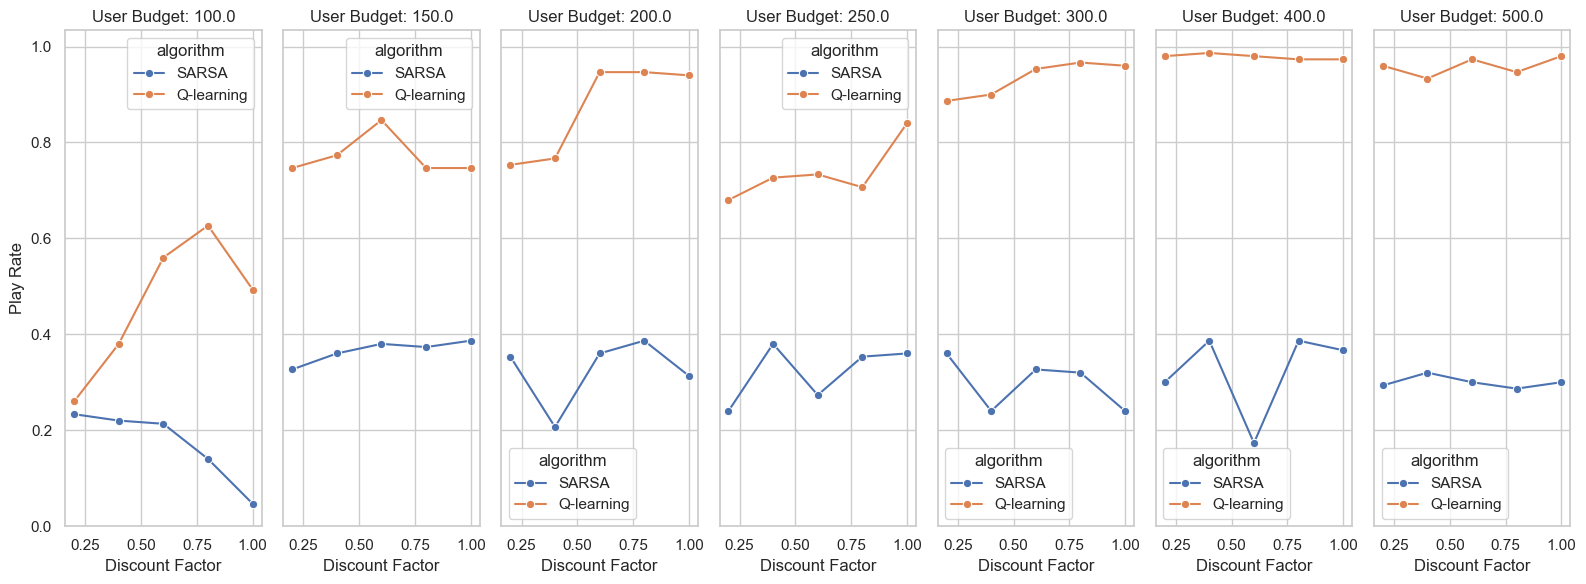

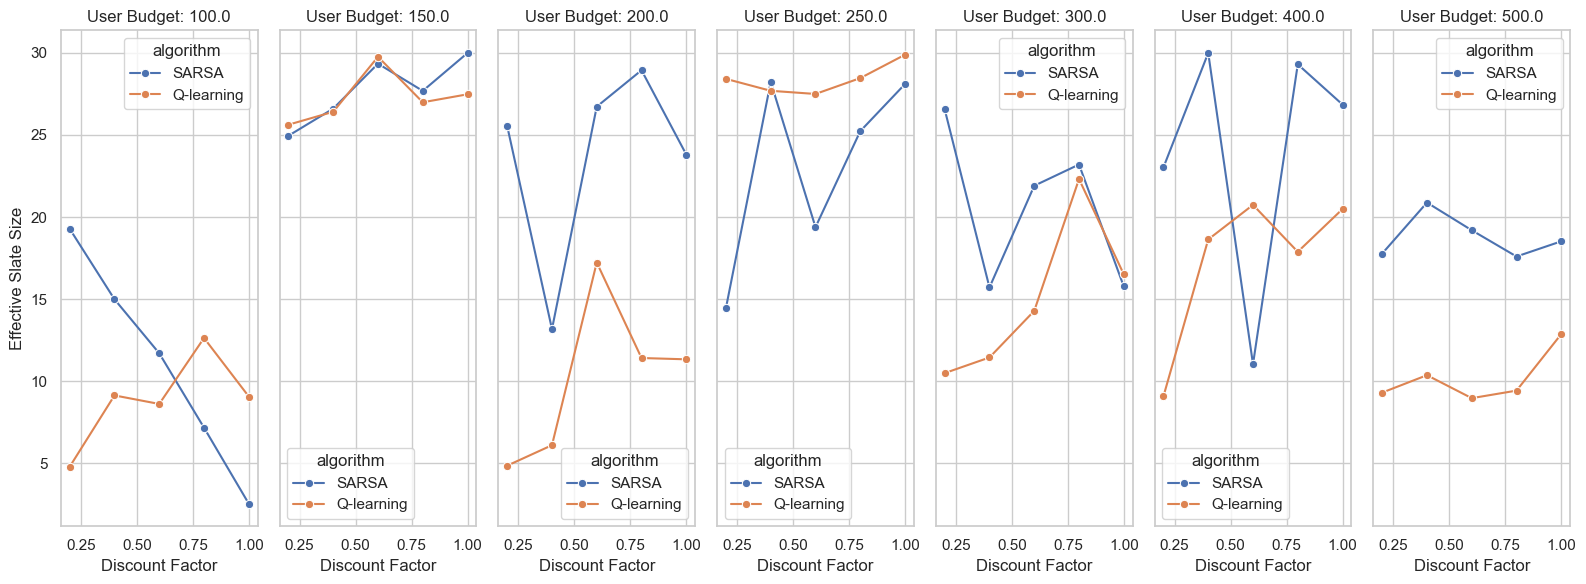

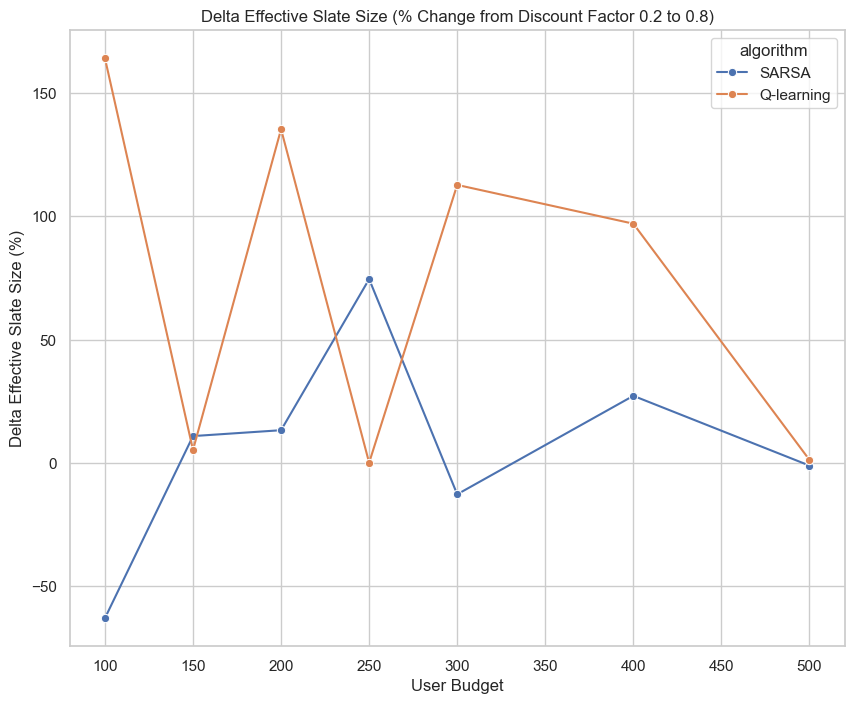

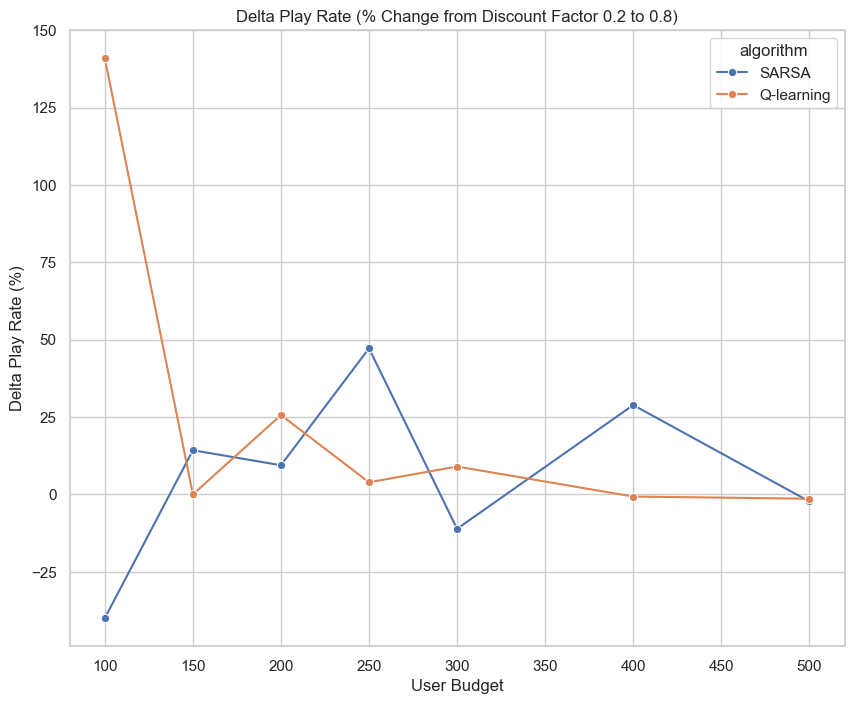

In [24]:
import pandas as pd
import ast

def txt_to_dataframe(file_path):
    """
    Reads a text file containing a dictionary of results, parses it, and converts it into a pandas DataFrame.

    Parameters:
    - file_path (str): The path to the 'results_sarsa.txt' or 'results_qlearning.txt' file.

    Returns:
    - pd.DataFrame: A DataFrame with extracted parameters and corresponding values.
    """
    # Read the content of the text file
    with open(file_path, 'r') as f:
        content = f.read()
    
    try:
        # Safely evaluate the string content to a Python dictionary
        data_dict = ast.literal_eval(content)
    except Exception as e:
        raise ValueError("Error parsing the text file. Ensure it contains a valid dictionary.") from e
    
    records = []
    
    for key, value in data_dict.items():
        # Initialize a dictionary to hold parameters for each record
        params = {}
        
        # Split the key string into individual parameter strings
        parts = key.split(',')
        for part in parts:
            # Remove any newline characters and extra spaces
            part = part.strip().replace('\n', '')
            if ':' in part:
                k, v = part.split(':', 1)
                k = k.strip()
                v = v.strip()
                params[k] = v
        
        # Convert numeric parameters to appropriate types
        for param in ['budget', 'discount_factor', 'num_users', 'num_docs', 'slate_size', 'epsilon', 'seed']:
            if param in params:
                try:
                    # Convert to float if there's a decimal point, else to int
                    if '.' in params[param]:
                        params[param] = float(params[param])
                    else:
                        params[param] = int(params[param])
                except ValueError:
                    # If conversion fails, keep the original string
                    pass
        
        # Extract 'play_rate' and 'effective_slate_size' by averaging if multiple entries exist
        if isinstance(value, list) and len(value) >= 2:
            final_play_rate = value[-1][0]
            final_imp_rate = value[-1][1]
            play_rate, effective_slate_size = final_play_rate, final_imp_rate
        elif isinstance(value, list) and len(value) == 1:
            play_rate, effective_slate_size = value[0]
        else:
            play_rate = None
            effective_slate_size = None
        
        params['play_rate'] = play_rate
        params['effective_slate_size'] = effective_slate_size
        
        # Append the parameters dictionary to the records list
        records.append(params)
    
    # Create a DataFrame from the list of records
    df = pd.DataFrame(records)
    
    # Rename 'budget' to 'user_budget' for clarity
    if 'budget' in df.columns:
        df = df.rename(columns={'budget': 'user_budget'})
    
    return df

df = txt_to_dataframe('results_sarsa.txt')
print(df.head())


# Install seaborn if not already installed
# !pip3 install seaborn

# Ensure necessary libraries are imported
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn theme
sns.set_theme(style="whitegrid")

# Function to convert txt to DataFrame (ensure this is defined as above)
# from your_module import txt_to_dataframe  # if saved separately

# Read the data from txt files
sarsa_results_df = txt_to_dataframe("results_sarsa.txt")
qlearning_results_df = txt_to_dataframe("results_qlearning.txt")

# Optionally, add an 'algorithm' column to differentiate between SARSA and Q-learning
sarsa_results_df['algorithm'] = 'SARSA'
qlearning_results_df['algorithm'] = 'Q-learning'

# Combine both DataFrames for comparative analysis
combined_df = pd.concat([sarsa_results_df, qlearning_results_df], ignore_index=True)

print(combined_df.head())

# Extract unique user budgets and sort them
user_budgets = np.sort(combined_df['user_budget'].unique())
print("User Budgets:", user_budgets)

# Plotting Play Rate vs. Discount Factor for each User Budget and Algorithm
f, axes = plt.subplots(nrows=1, ncols=len(user_budgets), figsize=(16, 6), sharex=True, sharey=True)

for n, ub in enumerate(user_budgets):
    ax = axes[n]
    sub_result = combined_df[combined_df.user_budget == ub]
    sns.lineplot(ax=ax, data=sub_result,
                 x='discount_factor', y='play_rate', hue='algorithm', marker='o')
    ax.set_title(f'User Budget: {ub}')
    ax.set_xlabel('Discount Factor')
    ax.set_ylabel('Play Rate')

plt.tight_layout()
plt.show()

# Plotting Effective Slate Size vs. Discount Factor for each User Budget and Algorithm
f, axes = plt.subplots(nrows=1, ncols=len(user_budgets), figsize=(16, 6), sharex=True, sharey=True)

for n, ub in enumerate(user_budgets):
    ax = axes[n]
    sub_result = combined_df[combined_df.user_budget == ub]
    sns.lineplot(ax=ax, data=sub_result,
                 x='discount_factor', y='effective_slate_size', hue='algorithm', marker='o')
    ax.set_title(f'User Budget: {ub}')
    ax.set_xlabel('Discount Factor')
    ax.set_ylabel('Effective Slate Size')

plt.tight_layout()
plt.show()

# Analyzing the Change in Metrics between discount_factor = 0.2 and 0.8
# Ensure that discount_factor = 0.2 and 0.8 exist
df_0_2 = combined_df[combined_df.discount_factor == 0.2].copy()
df_0_8 = combined_df[combined_df.discount_factor == 0.8].copy()

# Merge on 'user_budget' and 'algorithm' to compare SARSA and Q-learning
cb_vs_rl_df = pd.merge(df_0_2, df_0_8, on=['user_budget', 'algorithm'], suffixes=('_0_2', '_0_8'))

# Calculate percentage changes
cb_vs_rl_df['delta_play_rate'] = 100. * (cb_vs_rl_df['play_rate_0_8'] - cb_vs_rl_df['play_rate_0_2']) / cb_vs_rl_df['play_rate_0_2']
cb_vs_rl_df['delta_effective_slate_size'] = 100. * (cb_vs_rl_df['effective_slate_size_0_8'] - cb_vs_rl_df['effective_slate_size_0_2']) / cb_vs_rl_df['effective_slate_size_0_2']

# Plot Delta Effective Slate Size vs. User Budget
plt.figure(figsize=(10, 8))
sns.lineplot(data=cb_vs_rl_df, x='user_budget', y='delta_effective_slate_size', hue='algorithm', marker='o')
plt.title('Delta Effective Slate Size (% Change from Discount Factor 0.2 to 0.8)')
plt.xlabel('User Budget')
plt.ylabel('Delta Effective Slate Size (%)')
plt.show()

# Plot Delta Play Rate vs. User Budget
plt.figure(figsize=(10, 8))
sns.lineplot(data=cb_vs_rl_df, x='user_budget', y='delta_play_rate', hue='algorithm', marker='o')
plt.title('Delta Play Rate (% Change from Discount Factor 0.2 to 0.8)')
plt.xlabel('User Budget')
plt.ylabel('Delta Play Rate (%)')
plt.show()

<Axes: xlabel='user_budget', ylabel='delta_play_rate'>

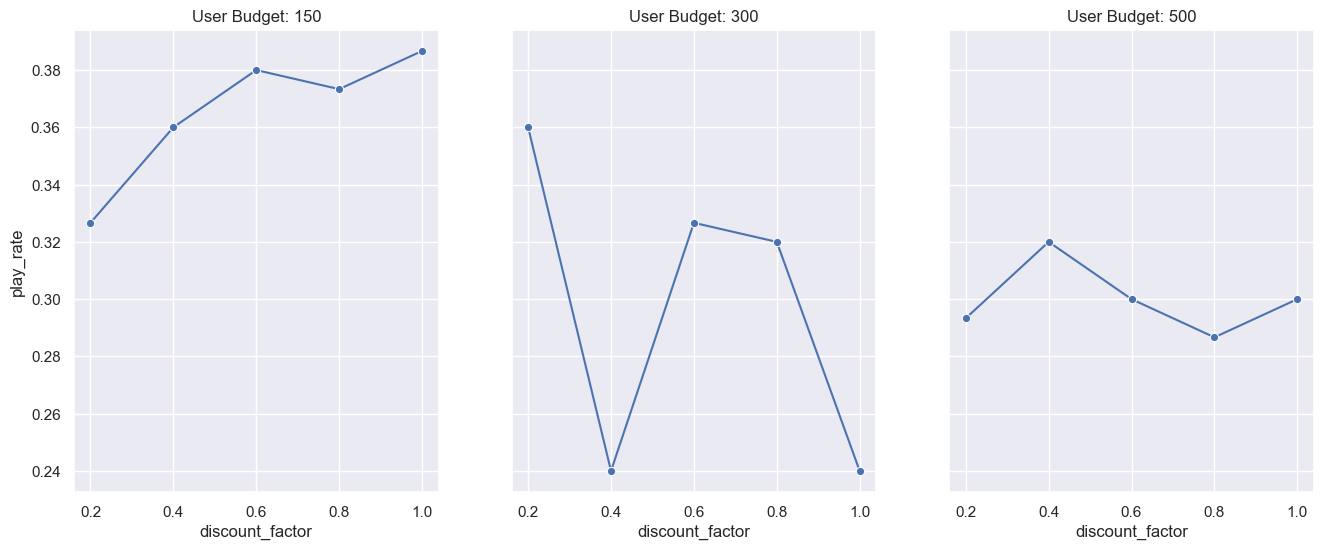

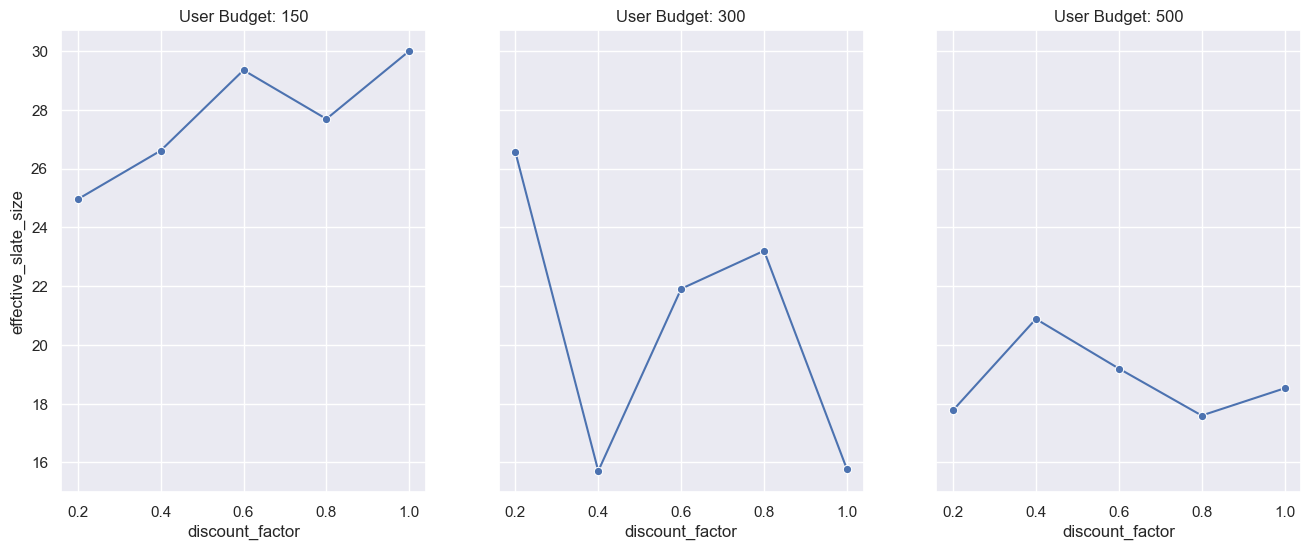

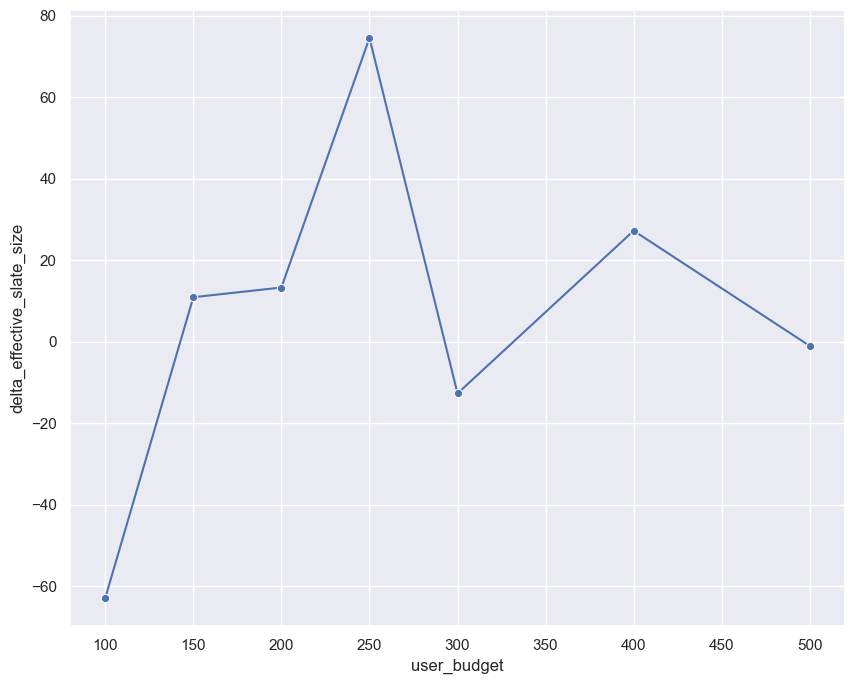

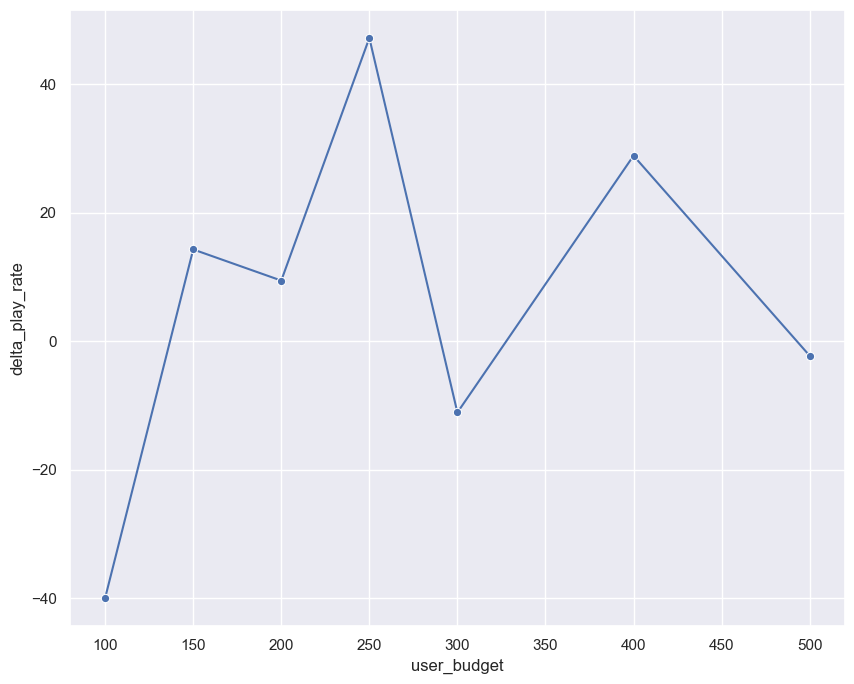

In [25]:
# import pickle as pkl
# sarsa_results = pkl.load(open('sarsa_results.pkl', 'rb'))
# qlearning_results = pkl.load(open('qlearning_results.pkl', 'rb'))

def make_results_df(all_results):
    df_list = []
    for b in sorted(all_results.keys()):
        for gamma in sorted(all_results[b].keys()):
            play_rates_for_seed = []
            imp_rates_for_seed = []
            seeds = []
            for seed, result_seq in all_results[b][gamma]:
                final_play_rate = result_seq[-1][0]
                final_imp_rate = result_seq[-1][1]
                play_rates_for_seed.append(final_play_rate)
                imp_rates_for_seed.append(final_imp_rate)
                seeds.append(seed)

            df_list.append(pd.DataFrame({'user_budget' : b,
                                         'discount_factor' : gamma,
                                         'seed' : seeds,
                                         'play_rate' : play_rates_for_seed,
                                         'effective_slate_size' : imp_rates_for_seed}))
    return pd.concat(df_list)


# sarsa_results_df = make_results_df(sarsa_results)
# sarsa_results_df = make_results_df(sarsa_results)

sarsa_results_df = txt_to_dataframe("results_sarsa.txt")
qlearning_results_df = txt_to_dataframe("results_qlearning.txt")

sns.set_theme('notebook')

user_budgets = np.sort(np.unique(sarsa_results_df.user_budget))
user_budgets = [150, 300, 500]
f, axes = plt.subplots(nrows=1, ncols=len(user_budgets), figsize=(16, 6), sharex=True, sharey=True)
for n, ub in enumerate(user_budgets):
    sub_result = sarsa_results_df[sarsa_results_df.user_budget == ub].reset_index()
    sns.lineplot(ax=axes[n], data = sub_result,
                 x = 'discount_factor', y = 'play_rate', marker='o').set(title=f'User Budget: {ub}')


f, axes = plt.subplots(nrows=1, ncols=len(user_budgets), figsize=(16, 6), sharex=True, sharey=True)
for n, ub in enumerate(user_budgets):
    sub_result = sarsa_results_df[sarsa_results_df.user_budget == ub].reset_index()
    sns.lineplot(ax=axes[n], data = sub_result,
                 x = 'discount_factor', y = 'effective_slate_size', marker='o').set(title=f'User Budget: {ub}')


sarsa_results_df_discount_factor_02 = sarsa_results_df[sarsa_results_df.discount_factor == 0.2].reset_index()
sarsa_results_df_discount_factor_08 = sarsa_results_df[sarsa_results_df.discount_factor == 0.8].reset_index()

cb_vs_rl_df = pd.merge(sarsa_results_df_discount_factor_02,
         sarsa_results_df_discount_factor_08, on = ['user_budget', 'seed'])

cb_vs_rl_df['delta_play_rate'] =\
100. * (cb_vs_rl_df['play_rate_y'] - cb_vs_rl_df['play_rate_x']) / (cb_vs_rl_df['play_rate_x'])

cb_vs_rl_df['delta_effective_slate_size'] =\
100. * (cb_vs_rl_df['effective_slate_size_y'] - cb_vs_rl_df['effective_slate_size_x']) / (cb_vs_rl_df['effective_slate_size_x'])

plt.figure(figsize=(10, 8))
sns.lineplot(data=cb_vs_rl_df, x = 'user_budget', y = 'delta_effective_slate_size', marker = 'o')

plt.figure(figsize=(10, 8))
sns.lineplot(data=cb_vs_rl_df, x = 'user_budget', y = 'delta_play_rate', marker = 'o')



# **Q-Learning Vs SARSA**

<Axes: xlabel='user_budget', ylabel='delta_play_rate'>

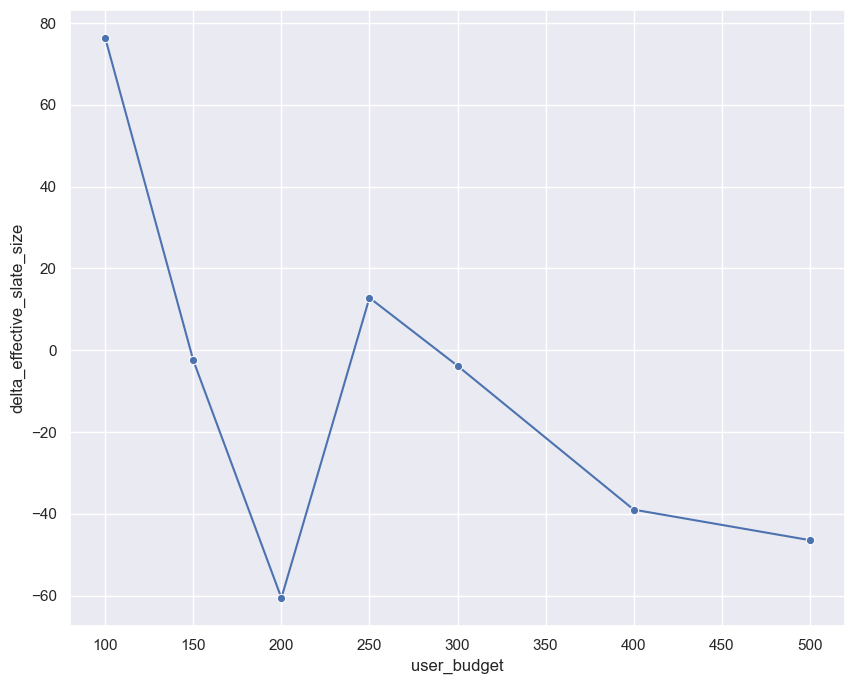

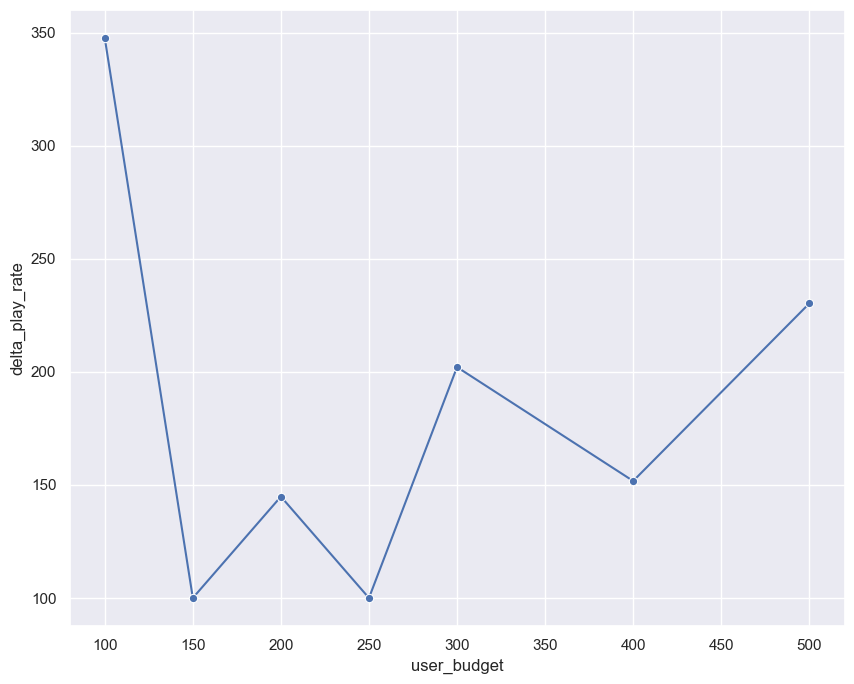

In [26]:
results_df_q_learning_discount_factor_08 = qlearning_results_df[qlearning_results_df.discount_factor == 0.8]

ql_vs_sarsa_df = pd.merge(results_df_q_learning_discount_factor_08,
                          sarsa_results_df_discount_factor_08, on = ['user_budget', 'seed'])

ql_vs_sarsa_df['delta_play_rate'] = 100.* (ql_vs_sarsa_df['play_rate_x'] - ql_vs_sarsa_df['play_rate_y']) / ql_vs_sarsa_df['play_rate_y']

ql_vs_sarsa_df['delta_effective_slate_size'] =\
100 * (ql_vs_sarsa_df['effective_slate_size_x'] - ql_vs_sarsa_df['effective_slate_size_y']) / (ql_vs_sarsa_df['effective_slate_size_y'])

plt.figure(figsize=(10, 8))
sns.lineplot(data=ql_vs_sarsa_df, x = 'user_budget', y = 'delta_effective_slate_size', marker = 'o')

plt.figure(figsize=(10, 8))
sns.lineplot(data=ql_vs_sarsa_df, x = 'user_budget', y = 'delta_play_rate', marker = 'o')

# User Activity Dataset (Additional Experiments)

In [27]:
import pandas as pd
# Define column names for the dataset
columns = [
    "page_id", 
    "hour", 
    "age_level", "gender", "purchase_power",
    "optional_feature",
    "positions", 
    "predicted_ctr", "predicted_cvr", "predicted_price",
    "is_click", "is_cart", #"is_fav", 
    "purchase_amount",
    # "optional_feature", 
    "is_last_page"
]

# Load the dataset
# Replace 'dataset.csv' with the actual path to your dataset
# df = pd.read_csv('data/www.data', names=columns, delimiter = ';',nrows = 8000)
df = pd.read_csv('data/rec_rl_data_small.txt', names=columns, delimiter = ';')

# Group by user features: age-level, gender, and purchase power
grouped_by_user = df.groupby(["age_level", "gender", "purchase_power"])

# Sort requests for each user group based on page ID
sorted_df = grouped_by_user.apply(lambda group: group.sort_values(by="page_id")).reset_index(drop=True)

/var/folders/pr/nt5zh26s11j2rpc1zxdkbfy40000gn/T/ipykernel_58366/3269011252.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sorted_df = grouped_by_user.apply(lambda group: group.sort_values(by="page_id")).reset_index(drop=True)


In [ ]:
df.head()

,page_id,hour,age_level,gender,purchase_power,optional_feature,positions,predicted_ctr,predicted_cvr,predicted_price,is_click,is_cart,purchase_amount,is_last_page
0,0,2,0,6,3,0,"168,160,190,154,188,155,173,180,176,179,169,16...","0.054926,0.038857,0.024458,0.052268,0.063737,0...","0.006565,0.012841,0.000207,0.007252,0.003,0.00...","29.0,49.0,880.0,68.0,25.8,620.0,52.0,89.0,68.0...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,0
1,0,2,0,6,1,0,"75,95,66,81,99,77,79,89,60,63,51,54,70,61,98,8...","0.036546,0.031251,0.021209,0.013102,0.03971,0....","0.004235,0.008282,0.020156,0.00465,0.002086,0....","65.0,29.3,55.0,128.0,78.0,39.8,19.9,40.0,38.9,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,0
2,0,2,0,6,2,0,"121,111,122,115,141,132,128,124,147,143,149,12...","0.038045,0.030227,0.029299,0.037582,0.027608,0...","0.011652,0.033843,0.030724,0.000085,0.0029,0.0...","20.0,19.9,19.9,2650.0,61.8,19.9,36.0,25.0,59.0...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,0
3,0,0,0,7,0,0,"6,13,7,11,18,15,8,14,17,2,0,9,16,5,10,4,12,3,1...","0.0,0.022527,0.025396,0.033908,0.009892,0.0223...","0.0,0.003091,0.002899,0.036787,0.008114,0.0073...","126.0,628.0,598.0,22.0,150.0,139.0,135.0,19.9,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,0
4,0,0,1,6,1,0,"82,86,91,93,81,92,97,83,89,98,95,96,84,90,94,8...","0.011527,0.023042,0.025272,0.003769,0.018711,0...","0.01468,0.00426,0.000096,0.013453,0.001435,0.0...","35.0,58.0,2800.0,99.0,438.0,58.0,148.5,960.0,1...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,0


In [ ]:
sorted_df.head(10)

,page_id,hour,age_level,gender,purchase_power,optional_feature,positions,predicted_ctr,predicted_cvr,predicted_price,is_click,is_cart,purchase_amount,is_last_page
0,0,0,0,2,0,0,"22,14,37,28,11,4,33,12,34,0,24,9,2,32,3,8,10,1...","0.084373,0.0,0.054622,0.0,0.039043,0.090748,0....","0.008686,0.0,0.01426,0.0,0.024865,0.005008,0.0...","17.6,148.0,15.8,117.0,23.8,55.0,78.0,20.8,35.9...","0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,0
1,0,0,0,2,2,0,"134,137,144,136,143,140,139,141,138,142,0,0,0,...","0.034752,0.174185,0.036235,0.059814,0.0,0.0551...","0.008034,0.000344,0.005521,0.004098,0.0,0.0045...","17.9,48.9,21.8,30.0,298.01,15.99,34.9,36.0,196...","1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...",0,0
2,0,0,0,3,0,0,"5,2,9,8,0,3,6,10,4,11,7,1,0,0,0,0,0,0,0,0,0,0,...","0.074792,0.036356,0.042693,0.062309,0.026273,0...","0.012601,0.018036,0.015166,0.002699,0.048848,0...","59.0,150.0,69.8,300.0,85.0,198.0,599.0,219.0,1...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,0
3,0,3,0,4,0,0,"2,33,0,12,15,20,22,16,4,25,1,17,27,32,5,7,14,9...","0.011616,0.033945,0.044558,0.026279,0.025073,0...","0.007166,0.005351,0.005493,0.007654,0.005466,0...","238.0,185.0,198.0,178.81,69.0,35.0,218.0,39.9,...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,0
4,0,1,0,4,0,0,"47,12,43,4,36,49,33,39,14,22,18,9,10,40,35,41,...","0.052464,0.056732,0.053061,0.052613,0.019559,0...","0.002826,0.002252,0.013433,0.003552,0.004602,0...","89.0,188.0,29.9,178.0,189.0,128.44,15.8,19.8,2...","0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,0
5,0,0,0,5,0,0,"6,13,10,44,32,41,23,36,34,42,1,7,22,45,0,19,30...","0.0,0.013412,0.0,0.028174,0.055241,0.012291,0....","0.0,0.028002,0.0,0.001585,0.002474,0.011658,0....","66.0,28.0,89.0,79.0,49.8,30.0,46.0,37.9,38.0,2...","0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,0
6,0,0,0,5,0,0,"49,9,0,40,13,1,6,32,47,7,20,15,26,43,22,42,39,...","0.022746,0.019774,0.020954,0.048486,0.023681,0...","0.005243,0.004072,0.028629,0.001309,0.020681,0...","69.0,202.0,68.0,248.0,29.9,30.99,185.0,39.0,39...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,0
7,0,0,0,5,0,0,"22,4,5,3,24,12,19,20,0,21,28,14,6,7,16,11,27,2...","0.03612,0.047882,0.024321,0.039152,0.02903,0.0...","0.003453,0.001412,0.013483,0.00316,0.007904,0....","59.0,198.0,79.0,158.0,38.8,68.0,11.6,285.0,58....","0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,0
8,0,0,0,5,0,0,"11,39,7,4,15,10,47,36,23,33,45,35,8,43,27,0,18...","0.045466,0.043663,0.0339,0.033729,0.06595,0.0,...","0.004892,0.002658,0.005963,0.00227,0.000559,0....","69.0,23.0,42.0,139.0,79.0,69.0,299.0,19.9,58.0...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,0
9,0,0,0,5,1,0,"83,65,63,75,57,76,92,59,95,89,54,56,61,53,78,9...","0.041305,0.03445,0.036062,0.037916,0.005569,0....","0.000476,0.00038,0.004273,0.001204,0.016786,0....","149.0,197.01,18.8,87.0,49.9,51.9,58.0,35.28,99...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....",0,0


In [ ]:
grouped_by_item = df.groupby(["predicted_ctr", "predicted_cvr", "predicted_price"])

In [ ]:
print(len(grouped_by_user))
print(len(grouped_by_item))

28
100


In [ ]:
item_relevance = df['predicted_ctr']
print(len(item_relevance[0]))
item_relevance.head(5)

,col6
0,"0.078572,0.085554,0.050164,0.096397,0.063206,0..."
1,"0.039829,0.05575,0.039993,0.054477,0.0891,0.05..."
2,"0.013293,0.018889,0.020094,0.004819,0.05179,0...."
3,"0.016651,0.009969,0.008817,0.064662,0.00413,0...."
4,"0.027804,0.009532,0.028581,0.007088,0.003281,0..."
